In [30]:
"""
Cette cellule installe tous les packages nécessaires pour l'analyse
"""
!pip install statsmodels pmdarima scipy scikit-learn -q
print("✓ Packages installés avec succès!")

✓ Packages installés avec succès!


In [31]:
"""
Import de toutes les bibliothèques nécessaires pour l'analyse
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques pour l'analyse de séries temporelles
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats

# Métriques d'évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

print("✓ Bibliothèques importées avec succès!")

✓ Bibliothèques importées avec succès!


In [32]:
"""
Paramètres pour générer la série temporelle
"""
print("=" * 70)
print("PARAMÈTRES DE GÉNÉRATION DE LA SÉRIE CHRONOLOGIQUE")
print("=" * 70)

# Paramètres de la série
n = 60              # Nombre total d'observations (5 ans × 12 mois)
beta0 = 100         # Intercept (niveau de base)
beta1 = 2           # Coefficient de tendance
A = 20              # Amplitude de la saisonnalité
P = 12              # Période (mensuelle)
sigma = 5           # Écart-type du bruit blanc

# Paramètres de séparation train/test
train_size = 48     # 4 ans pour l'entraînement
test_size = 12      # 1 an pour le test

# Affichage des paramètres
params_df = pd.DataFrame({
    'Paramètre': ['n', 'beta0', 'beta1', 'A', 'P', 'sigma', 'Train', 'Test'],
    'Valeur': [n, beta0, beta1, A, P, sigma, train_size, test_size],
    'Description': [
        'Nombre total d\'observations',
        'Niveau de base (intercept)',
        'Pente de la tendance',
        'Amplitude de la saisonnalité',
        'Période (12 = mensuel)',
        'Écart-type du bruit',
        'Taille ensemble d\'entraînement',
        'Taille ensemble de test'
    ]
})
print("\n", params_df.to_string(index=False))
print("\n✓ Paramètres définis")

PARAMÈTRES DE GÉNÉRATION DE LA SÉRIE CHRONOLOGIQUE

 Paramètre  Valeur                    Description
        n      60    Nombre total d'observations
    beta0     100     Niveau de base (intercept)
    beta1       2           Pente de la tendance
        A      20   Amplitude de la saisonnalité
        P      12         Période (12 = mensuel)
    sigma       5            Écart-type du bruit
    Train      48 Taille ensemble d'entraînement
     Test      12        Taille ensemble de test

✓ Paramètres définis


In [33]:
"""
Génération de la série avec tendance + saisonnalité + bruit
Formule: Y(t) = beta0 + beta1*t + A*sin(2π*t/P) + ε(t)
"""
print("\n" + "=" * 70)
print("GÉNÉRATION DE LA SÉRIE TEMPORELLE")
print("=" * 70)

# Fixer la graine aléatoire pour la reproductibilité
np.random.seed(42)

# Génération du vecteur temps
t = np.arange(1, n + 1)

# Composante 1: Tendance linéaire
tendance = beta0 + beta1 * t
print(f"\n1. Tendance: Y_tendance = {beta0} + {beta1} × t")
print(f"   Début: {tendance[0]:.2f}, Fin: {tendance[-1]:.2f}")

# Composante 2: Saisonnalité sinusoïdale
saisonnalite = A * np.sin(2 * np.pi * t / P)
print(f"\n2. Saisonnalité: Y_saison = {A} × sin(2π × t / {P})")
print(f"   Amplitude: ±{A}, Période: {P} mois")

# Composante 3: Bruit blanc gaussien
bruit = np.random.normal(0, sigma, n)
print(f"\n3. Bruit: ε ~ N(0, {sigma}²)")
print(f"   Moyenne: {np.mean(bruit):.4f}, Écart-type: {np.std(bruit):.4f}")

# Série temporelle complète
ventes = tendance + saisonnalite + bruit
print(f"\n4. Série complète: Y(t) = Tendance + Saisonnalité + Bruit")
print(f"   Min: {ventes.min():.2f}, Max: {ventes.max():.2f}, Moyenne: {ventes.mean():.2f}")

# Création du DataFrame avec dates
date_debut = pd.Timestamp('2020-01-01')
dates = pd.date_range(start=date_debut, periods=n, freq='MS')  # MS = Month Start
df = pd.DataFrame({
    'date': dates,
    'ventes': ventes,
    'tendance': tendance,
    'saisonnalite': saisonnalite,
    'bruit': bruit
})
df.set_index('date', inplace=True)

print("\n✓ Série générée avec succès!")
print(f"   Période: {df.index[0].strftime('%Y-%m')} à {df.index[-1].strftime('%Y-%m')}")


GÉNÉRATION DE LA SÉRIE TEMPORELLE

1. Tendance: Y_tendance = 100 + 2 × t
   Début: 102.00, Fin: 220.00

2. Saisonnalité: Y_saison = 20 × sin(2π × t / 12)
   Amplitude: ±20, Période: 12 mois

3. Bruit: ε ~ N(0, 5²)
   Moyenne: -0.7733, Écart-type: 4.5046

4. Série complète: Y(t) = Tendance + Saisonnalité + Bruit
   Min: 95.65, Max: 224.88, Moyenne: 160.23

✓ Série générée avec succès!
   Période: 2020-01 à 2024-12


In [34]:
"""
Affichage et statistiques descriptives de la série
"""
print("\n" + "=" * 70)
print("APERÇU DES DONNÉES GÉNÉRÉES")
print("=" * 70)

print("\n--- Premières observations ---")
print(df.head(12))

print("\n--- Dernières observations ---")
print(df.tail(12))

print("\n--- Statistiques descriptives ---")
stats_desc = df[['ventes']].describe()
print(stats_desc)

# Statistiques supplémentaires
print("\n--- Statistiques supplémentaires ---")
print(f"Médiane: {df['ventes'].median():.2f}")
print(f"Variance: {df['ventes'].var():.2f}")
print(f"Coefficient de variation: {(df['ventes'].std() / df['ventes'].mean() * 100):.2f}%")
print(f"Skewness (asymétrie): {df['ventes'].skew():.4f}")
print(f"Kurtosis (aplatissement): {df['ventes'].kurtosis():.4f}")


APERÇU DES DONNÉES GÉNÉRÉES

--- Premières observations ---
                ventes  tendance  saisonnalite     bruit
date                                                    
2020-01-01  114.483571       102  1.000000e+01  2.483571
2020-02-01  120.629187       104  1.732051e+01 -0.691322
2020-03-01  129.238443       106  2.000000e+01  3.238443
2020-04-01  132.935657       108  1.732051e+01  7.615149
2020-05-01  118.829233       110  1.000000e+01 -1.170767
2020-06-01  110.829315       112  2.449294e-15 -1.170685
2020-07-01  111.896064       114 -1.000000e+01  7.896064
2020-08-01  102.516666       116 -1.732051e+01  3.837174
2020-09-01   95.652628       118 -2.000000e+01 -2.347372
2020-10-01  105.392292       120 -1.732051e+01  2.712800
2020-11-01  109.682912       122 -1.000000e+01 -2.317088
2020-12-01  121.671351       124 -4.898587e-15 -2.328649

--- Dernières observations ---
                ventes  tendance  saisonnalite     bruit
date                                                


VISUALISATION 1: SÉRIE ET COMPOSANTES


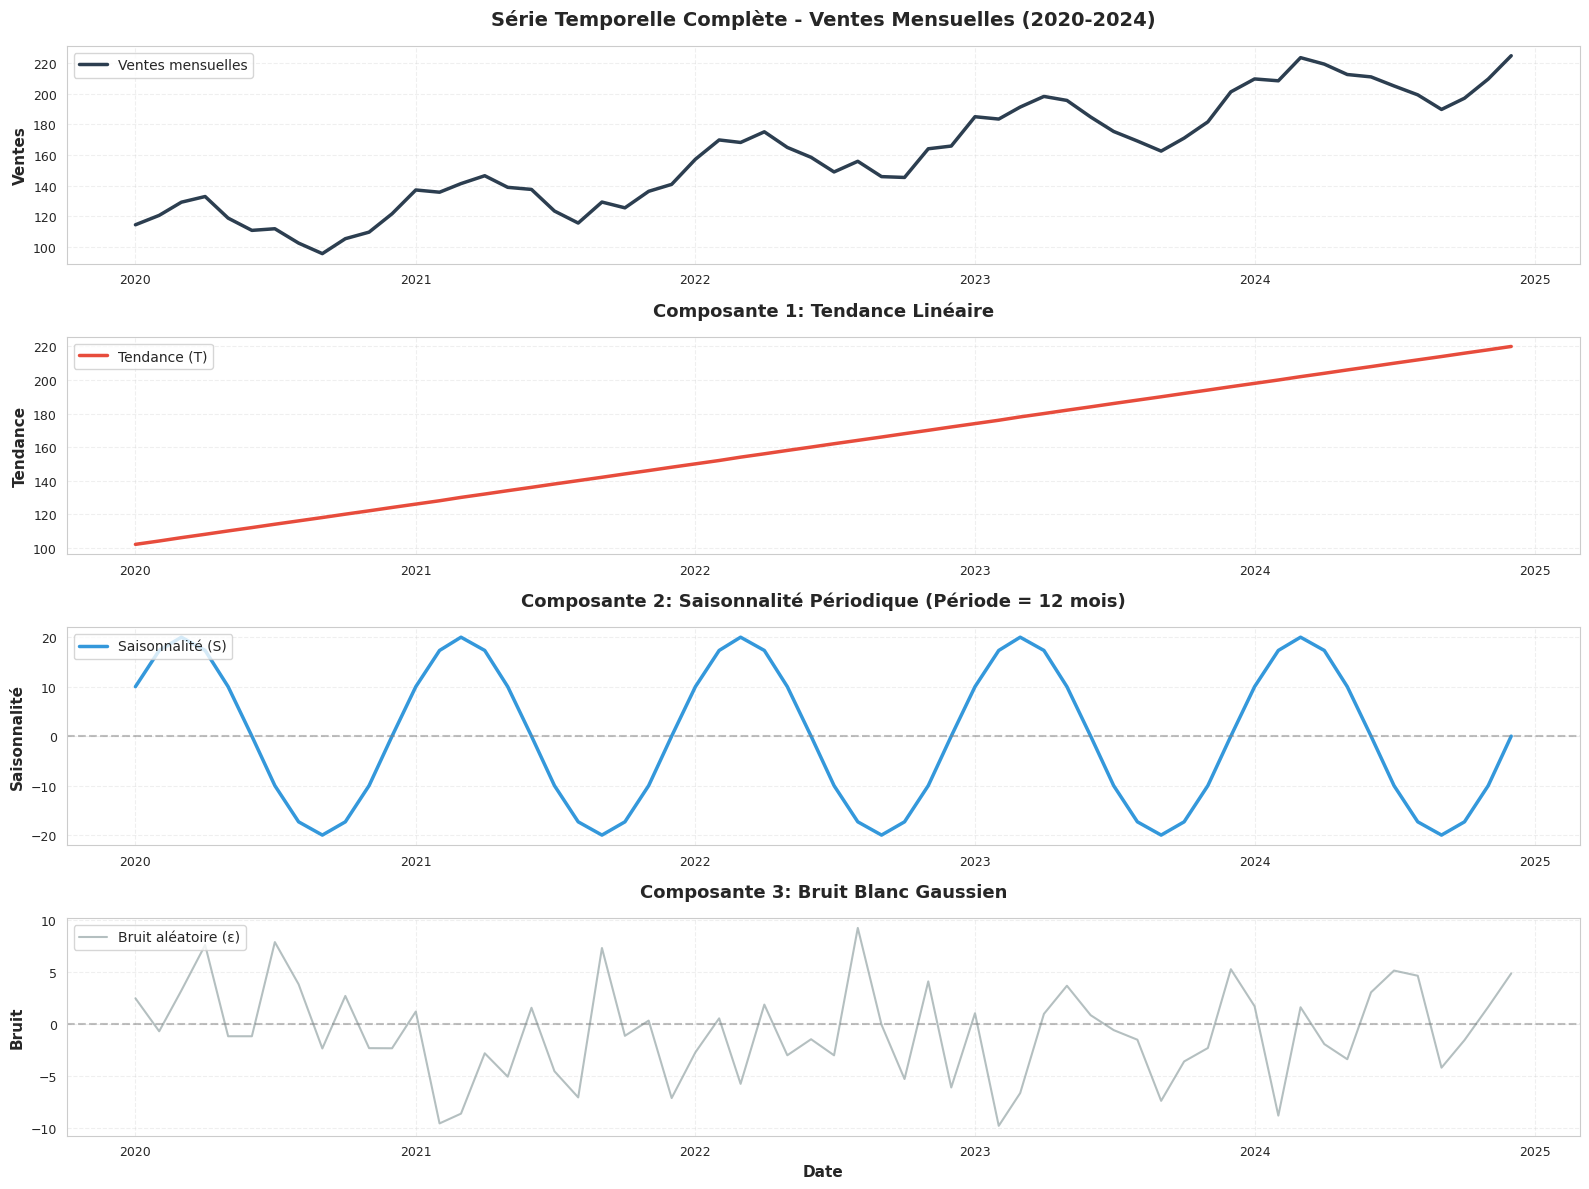

✓ Graphique affiché

INTERPRÉTATION:
- La série présente une TENDANCE CROISSANTE LINÉAIRE
- On observe une SAISONNALITÉ RÉGULIÈRE avec période de 12 mois
- Le BRUIT est aléatoire et centré autour de zéro


In [35]:
# ========================================================================
# CELLULE 6: VISUALISATION 1 - SÉRIE COMPLÈTE AVEC COMPOSANTES
# ========================================================================
"""
Visualisation de la série temporelle et de ses composantes
"""
print("\n" + "=" * 70)
print("VISUALISATION 1: SÉRIE ET COMPOSANTES")
print("=" * 70)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Graphique 1: Série complète
axes[0].plot(df.index, df['ventes'], linewidth=2.5, color='#2C3E50', label='Ventes mensuelles')
axes[0].set_title('Série Temporelle Complète - Ventes Mensuelles (2020-2024)',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Ventes', fontsize=11, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].tick_params(axis='both', which='major', labelsize=9)

# Graphique 2: Tendance
axes[1].plot(df.index, df['tendance'], linewidth=2.5, color='#E74C3C', label='Tendance (T)')
axes[1].set_title('Composante 1: Tendance Linéaire', fontsize=13, fontweight='bold', pad=15)
axes[1].set_ylabel('Tendance', fontsize=11, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].tick_params(axis='both', which='major', labelsize=9)

# Graphique 3: Saisonnalité
axes[2].plot(df.index, df['saisonnalite'], linewidth=2.5, color='#3498DB', label='Saisonnalité (S)')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Composante 2: Saisonnalité Périodique (Période = 12 mois)',
                  fontsize=13, fontweight='bold', pad=15)
axes[2].set_ylabel('Saisonnalité', fontsize=11, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=10)
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].tick_params(axis='both', which='major', labelsize=9)

# Graphique 4: Bruit
axes[3].plot(df.index, df['bruit'], linewidth=1.5, color='#95A5A6', alpha=0.7, label='Bruit aléatoire (ε)')
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].set_title('Composante 3: Bruit Blanc Gaussien', fontsize=13, fontweight='bold', pad=15)
axes[3].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[3].set_ylabel('Bruit', fontsize=11, fontweight='bold')
axes[3].legend(loc='upper left', fontsize=10)
axes[3].grid(True, alpha=0.3, linestyle='--')
axes[3].tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()

print("✓ Graphique affiché")
print("\nINTERPRÉTATION:")
print("- La série présente une TENDANCE CROISSANTE LINÉAIRE")
print("- On observe une SAISONNALITÉ RÉGULIÈRE avec période de 12 mois")
print("- Le BRUIT est aléatoire et centré autour de zéro")


VISUALISATION 2: DÉCOMPOSITION ADDITIVE


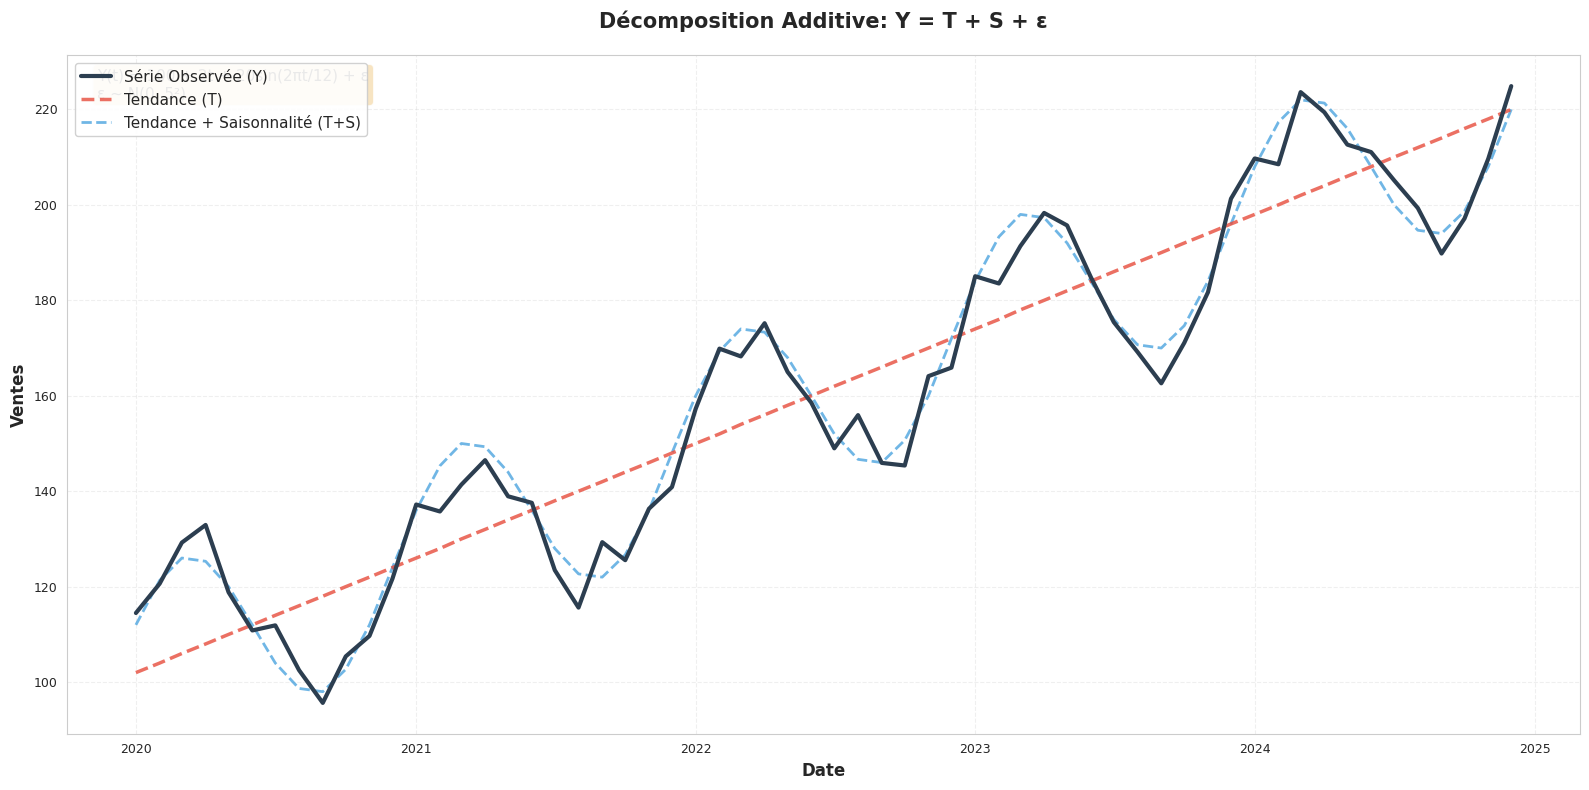

✓ Graphique affiché

FORMULE DU MODÈLE ADDITIF:
Y(t) = T(t) + S(t) + ε(t)
     = (100 + 2t) + 20sin(2πt/12) + ε
où ε ~ N(0, 5²)


In [36]:
"""
Superposition de toutes les composantes pour mieux comprendre la décomposition
"""
print("\n" + "=" * 70)
print("VISUALISATION 2: DÉCOMPOSITION ADDITIVE")
print("=" * 70)

fig, ax = plt.subplots(figsize=(16, 8))

# Tracer toutes les composantes
ax.plot(df.index, df['ventes'], linewidth=3, color='#2C3E50',
        label='Série Observée (Y)', zorder=4)
ax.plot(df.index, df['tendance'], linewidth=2.5, color='#E74C3C',
        linestyle='--', label='Tendance (T)', alpha=0.8, zorder=3)
ax.plot(df.index, df['tendance'] + df['saisonnalite'], linewidth=2,
        color='#3498DB', linestyle='--', label='Tendance + Saisonnalité (T+S)',
        alpha=0.7, zorder=2)

ax.set_title('Décomposition Additive: Y = T + S + ε',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Ajouter une zone de texte avec la formule
textstr = f'Y(t) = {beta0} + {beta1}t + {A}sin(2πt/{P}) + ε\nε ~ N(0, {sigma}²)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("✓ Graphique affiché")
print("\nFORMULE DU MODÈLE ADDITIF:")
print(f"Y(t) = T(t) + S(t) + ε(t)")
print(f"     = ({beta0} + {beta1}t) + {A}sin(2πt/{P}) + ε")
print(f"où ε ~ N(0, {sigma}²)")


SÉPARATION TRAIN / TEST

📊 Ensemble d'ENTRAÎNEMENT:
   - Période: 2020-01 à 2023-12
   - Nombre d'observations: 48
   - Moyenne: 147.97
   - Écart-type: 28.18

🎯 Ensemble de TEST:
   - Période: 2024-01 à 2024-12
   - Nombre d'observations: 12
   - Moyenne: 209.24
   - Écart-type: 10.48


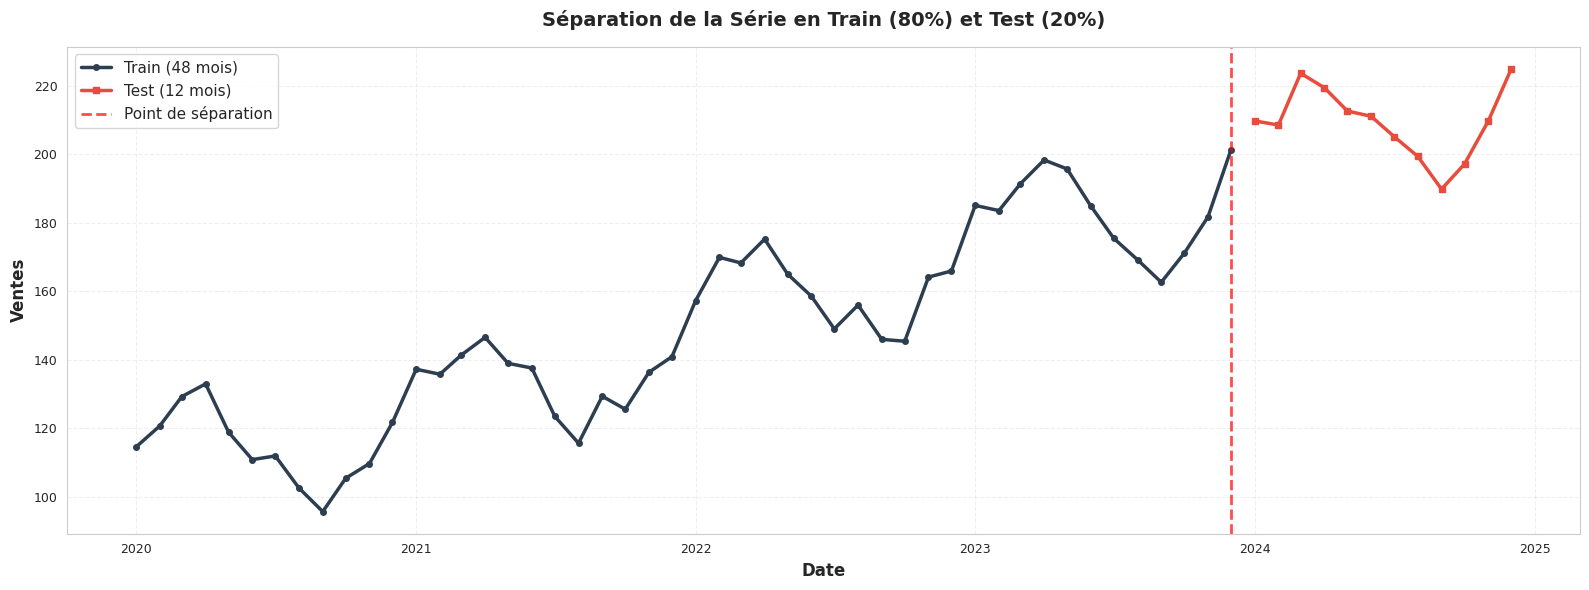


✓ Séparation effectuée


In [37]:
"""
Division de la série en ensemble d'entraînement et de test
"""
print("\n" + "=" * 70)
print("SÉPARATION TRAIN / TEST")
print("=" * 70)

# Séparation
train = df[['ventes']].iloc[:train_size]
test = df[['ventes']].iloc[train_size:]

print(f"\n📊 Ensemble d'ENTRAÎNEMENT:")
print(f"   - Période: {train.index[0].strftime('%Y-%m')} à {train.index[-1].strftime('%Y-%m')}")
print(f"   - Nombre d'observations: {len(train)}")
print(f"   - Moyenne: {train['ventes'].mean():.2f}")
print(f"   - Écart-type: {train['ventes'].std():.2f}")

print(f"\n🎯 Ensemble de TEST:")
print(f"   - Période: {test.index[0].strftime('%Y-%m')} à {test.index[-1].strftime('%Y-%m')}")
print(f"   - Nombre d'observations: {len(test)}")
print(f"   - Moyenne: {test['ventes'].mean():.2f}")
print(f"   - Écart-type: {test['ventes'].std():.2f}")

# Visualisation de la séparation
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train.index, train['ventes'], linewidth=2.5, color='#2C3E50',
        label='Train (48 mois)', marker='o', markersize=4)
ax.plot(test.index, test['ventes'], linewidth=2.5, color='#E74C3C',
        label='Test (12 mois)', marker='s', markersize=4)
ax.axvline(x=train.index[-1], color='red', linestyle='--', linewidth=2,
           alpha=0.7, label='Point de séparation')
ax.set_title('Séparation de la Série en Train (80%) et Test (20%)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Séparation effectuée")


STATISTIQUES DESCRIPTIVES DÉTAILLÉES

--- Statistiques par année ---
       Nombre  Moyenne  Écart-type     Min     Max  Médiane
annee                                                      
2020       12   114.48       10.83   95.65  132.94   113.19
2021       12   134.04        8.82  115.62  146.51   136.77
2022       12   160.03        9.68  145.39  175.20   161.33
2023       12   183.34       12.11  162.61  201.29   184.19
2024       12   209.24       10.48  189.80  224.88   209.69

--- Statistiques par mois (tous les ans confondus) ---
      Nombre  Moyenne  Écart-type
Jan        5   160.75       37.73
Fév        5   163.66       35.62
Mar        5   170.77       38.12
Avr        5   174.47       35.69
Mai        5   166.21       38.77
Juin       5   160.57       39.20
Juil       5   152.98       38.08
Août       5   148.52       39.57
Sep        5   144.66       35.35
Oct        5   148.91       36.29
Nov        5   160.30       38.87
Déc        5   170.92       42.39


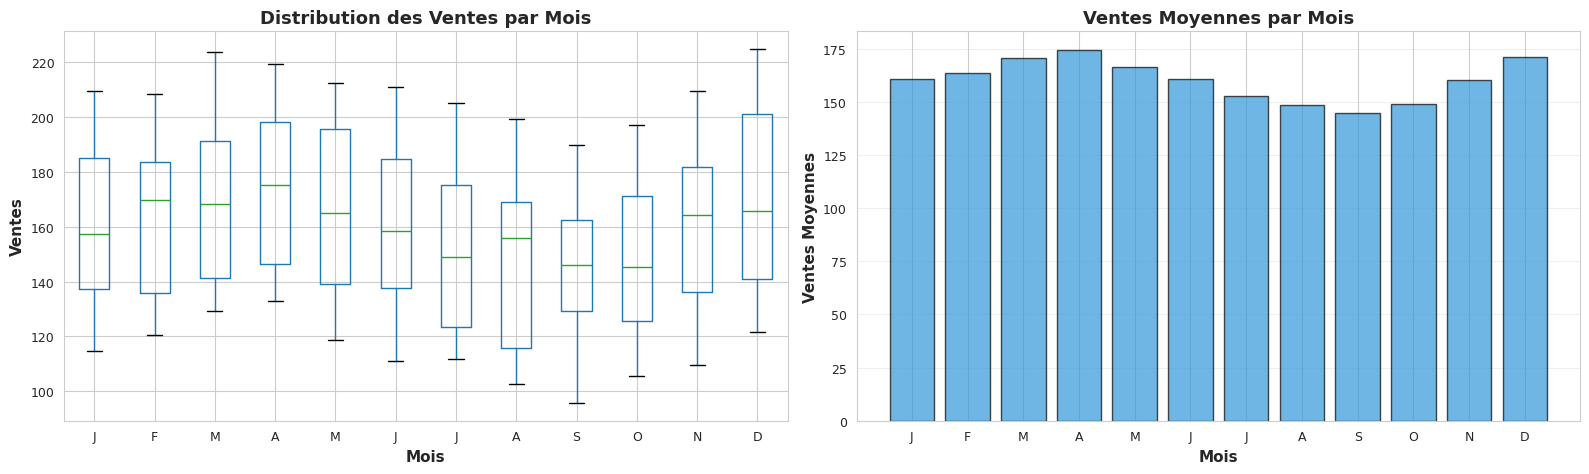


✓ Statistiques calculées et visualisées


In [38]:
"""
Analyse statistique approfondie de la série
"""
print("\n" + "=" * 70)
print("STATISTIQUES DESCRIPTIVES DÉTAILLÉES")
print("=" * 70)

# Statistiques par année
df_stats = df[['ventes']].copy()
df_stats['annee'] = df_stats.index.year
df_stats['mois'] = df_stats.index.month

print("\n--- Statistiques par année ---")
stats_annee = df_stats.groupby('annee')['ventes'].agg([
    ('Nombre', 'count'),
    ('Moyenne', 'mean'),
    ('Écart-type', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Médiane', 'median')
]).round(2)
print(stats_annee)

print("\n--- Statistiques par mois (tous les ans confondus) ---")
stats_mois = df_stats.groupby('mois')['ventes'].agg([
    ('Nombre', 'count'),
    ('Moyenne', 'mean'),
    ('Écart-type', 'std')
]).round(2)
stats_mois.index = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin',
                     'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
print(stats_mois)

# Visualisation des statistiques par mois
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Boxplot par mois
df_stats.boxplot(column='ventes', by='mois', ax=axes[0])
axes[0].set_title('Distribution des Ventes par Mois', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Mois', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Ventes', fontsize=11, fontweight='bold')
axes[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.suptitle('')

# Moyenne par mois
axes[1].bar(range(1, 13), stats_mois['Moyenne'], color='#3498DB', alpha=0.7, edgecolor='black')
axes[1].set_title('Ventes Moyennes par Mois', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Mois', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Ventes Moyennes', fontsize=11, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Statistiques calculées et visualisées")


TEST DE NORMALITÉ DU BRUIT

--- Test de Shapiro-Wilk ---
Statistique: 0.9880
P-value: 0.8232
✓ Le bruit suit une distribution NORMALE (p > 0.05)

--- Test de Jarque-Bera ---
Statistique: 0.6523
P-value: 0.7217
✓ Le bruit suit une distribution NORMALE (p > 0.05)


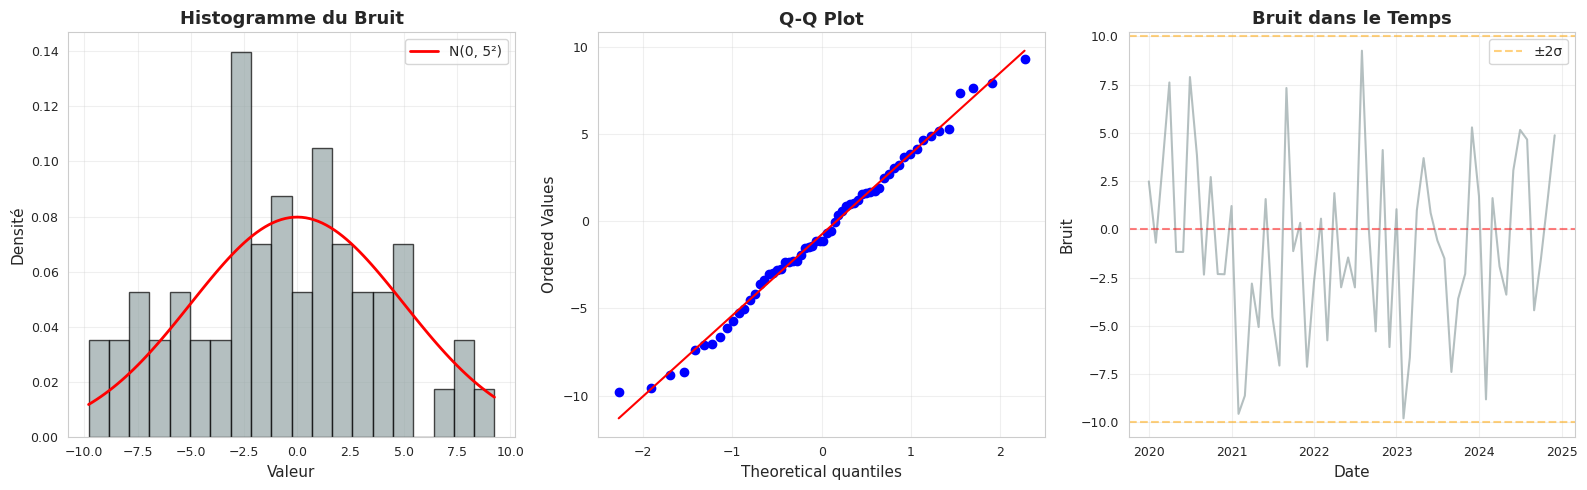


✓ Tests de normalité effectués


In [39]:
"""
Vérification que le bruit suit une distribution normale
"""
print("\n" + "=" * 70)
print("TEST DE NORMALITÉ DU BRUIT")
print("=" * 70)

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df['bruit'])
print(f"\n--- Test de Shapiro-Wilk ---")
print(f"Statistique: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("✓ Le bruit suit une distribution NORMALE (p > 0.05)")
else:
    print("✗ Le bruit ne suit PAS une distribution normale (p ≤ 0.05)")

# Test de Jarque-Bera
jb_stat, jb_p = stats.jarque_bera(df['bruit'])
print(f"\n--- Test de Jarque-Bera ---")
print(f"Statistique: {jb_stat:.4f}")
print(f"P-value: {jb_p:.4f}")
if jb_p > 0.05:
    print("✓ Le bruit suit une distribution NORMALE (p > 0.05)")
else:
    print("✗ Le bruit ne suit PAS une distribution normale (p ≤ 0.05)")

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogramme
axes[0].hist(df['bruit'], bins=20, density=True, alpha=0.7, color='#95A5A6', edgecolor='black')
# Courbe normale théorique
x = np.linspace(df['bruit'].min(), df['bruit'].max(), 100)
axes[0].plot(x, stats.norm.pdf(x, 0, sigma), 'r-', linewidth=2, label=f'N(0, {sigma}²)')
axes[0].set_title('Histogramme du Bruit', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Valeur', fontsize=11)
axes[0].set_ylabel('Densité', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(df['bruit'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Série temporelle du bruit
axes[2].plot(df.index, df['bruit'], linewidth=1.5, color='#95A5A6', alpha=0.7)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(y=2*sigma, color='orange', linestyle='--', alpha=0.5, label='±2σ')
axes[2].axhline(y=-2*sigma, color='orange', linestyle='--', alpha=0.5)
axes[2].set_title('Bruit dans le Temps', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Bruit', fontsize=11)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Tests de normalité effectués")

In [40]:
"""
Tests statistiques pour déterminer si la série est stationnaire
"""
print("\n" + "=" * 70)
print("TESTS DE STATIONNARITÉ")
print("=" * 70)

print("\n📚 RAPPEL THÉORIQUE:")
print("Une série est STATIONNAIRE si:")
print("  1. Moyenne constante dans le temps")
print("  2. Variance constante dans le temps")
print("  3. Covariance dépend seulement du décalage, pas du temps")

# Test ADF (Augmented Dickey-Fuller)
print("\n" + "-" * 70)
print("TEST 1: ADF (Augmented Dickey-Fuller)")
print("-" * 70)
print("H0: La série possède une racine unitaire (NON stationnaire)")
print("H1: La série est stationnaire")

adf_result = adfuller(train['ventes'], autolag='AIC')
print(f"\nStatistique ADF: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print(f"Nombre de lags utilisés: {adf_result[2]}")
print(f"Nombre d'observations: {adf_result[3]}")
print(f"\nValeurs critiques:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n✓ CONCLUSION: La série est STATIONNAIRE (on rejette H0, p < 0.05)")
else:
    print("\n✗ CONCLUSION: La série est NON STATIONNAIRE (on ne rejette pas H0, p ≥ 0.05)")

# Test KPSS
print("\n" + "-" * 70)
print("TEST 2: KPSS (Kwiatkowski-Phillips-Schmidt-Shin)")
print("-" * 70)
print("H0: La série est stationnaire")
print("H1: La série possède une racine unitaire (NON stationnaire)")

kpss_result = kpss(train['ventes'], regression='ct', nlags='auto')
print(f"\nStatistique KPSS: {kpss_result[0]:.4f}")
print(f"P-value: {kpss_result[1]:.4f}")
print(f"Nombre de lags utilisés: {kpss_result[2]}")
print(f"\nValeurs critiques:")
for key, value in kpss_result[3].items():
    print(f"  {key}: {value:.4f}")

if kpss_result[1] > 0.05:
    print("\n✓ CONCLUSION: La série est STATIONNAIRE (on ne rejette pas H0, p > 0.05)")
else:
    print("\n✗ CONCLUSION: La série est NON STATIONNAIRE (on rejette H0, p ≤ 0.05)")

# Résumé
print("\n" + "=" * 70)
print("RÉSUMÉ DES TESTS DE STATIONNARITÉ")
print("=" * 70)
print(f"Test ADF:  {'STATIONNAIRE' if adf_result[1] < 0.05 else 'NON STATIONNAIRE'} (p={adf_result[1]:.4f})")
print(f"Test KPSS: {'STATIONNAIRE' if kpss_result[1] > 0.05 else 'NON STATIONNAIRE'} (p={kpss_result[1]:.4f})")
print("\n🎯 CONCLUSION FINALE:")
if adf_result[1] >= 0.05 or kpss_result[1] <= 0.05:
    print("   La série est NON STATIONNAIRE")
    print("   Raison: Présence de TENDANCE et/ou SAISONNALITÉ")
    print("   Solution: Différenciation nécessaire")
else:
    print("   La série est STATIONNAIRE")


TESTS DE STATIONNARITÉ

📚 RAPPEL THÉORIQUE:
Une série est STATIONNAIRE si:
  1. Moyenne constante dans le temps
  2. Variance constante dans le temps
  3. Covariance dépend seulement du décalage, pas du temps

----------------------------------------------------------------------
TEST 1: ADF (Augmented Dickey-Fuller)
----------------------------------------------------------------------
H0: La série possède une racine unitaire (NON stationnaire)
H1: La série est stationnaire

Statistique ADF: 1.2312
P-value: 0.9962
Nombre de lags utilisés: 10
Nombre d'observations: 37

Valeurs critiques:
  1%: -3.6209
  5%: -2.9435
  10%: -2.6104

✗ CONCLUSION: La série est NON STATIONNAIRE (on ne rejette pas H0, p ≥ 0.05)

----------------------------------------------------------------------
TEST 2: KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
----------------------------------------------------------------------
H0: La série est stationnaire
H1: La série possède une racine unitaire (NON stationnaire)




ANALYSE DE LA STATIONNARITÉ: MOYENNE ET VARIANCE MOBILES


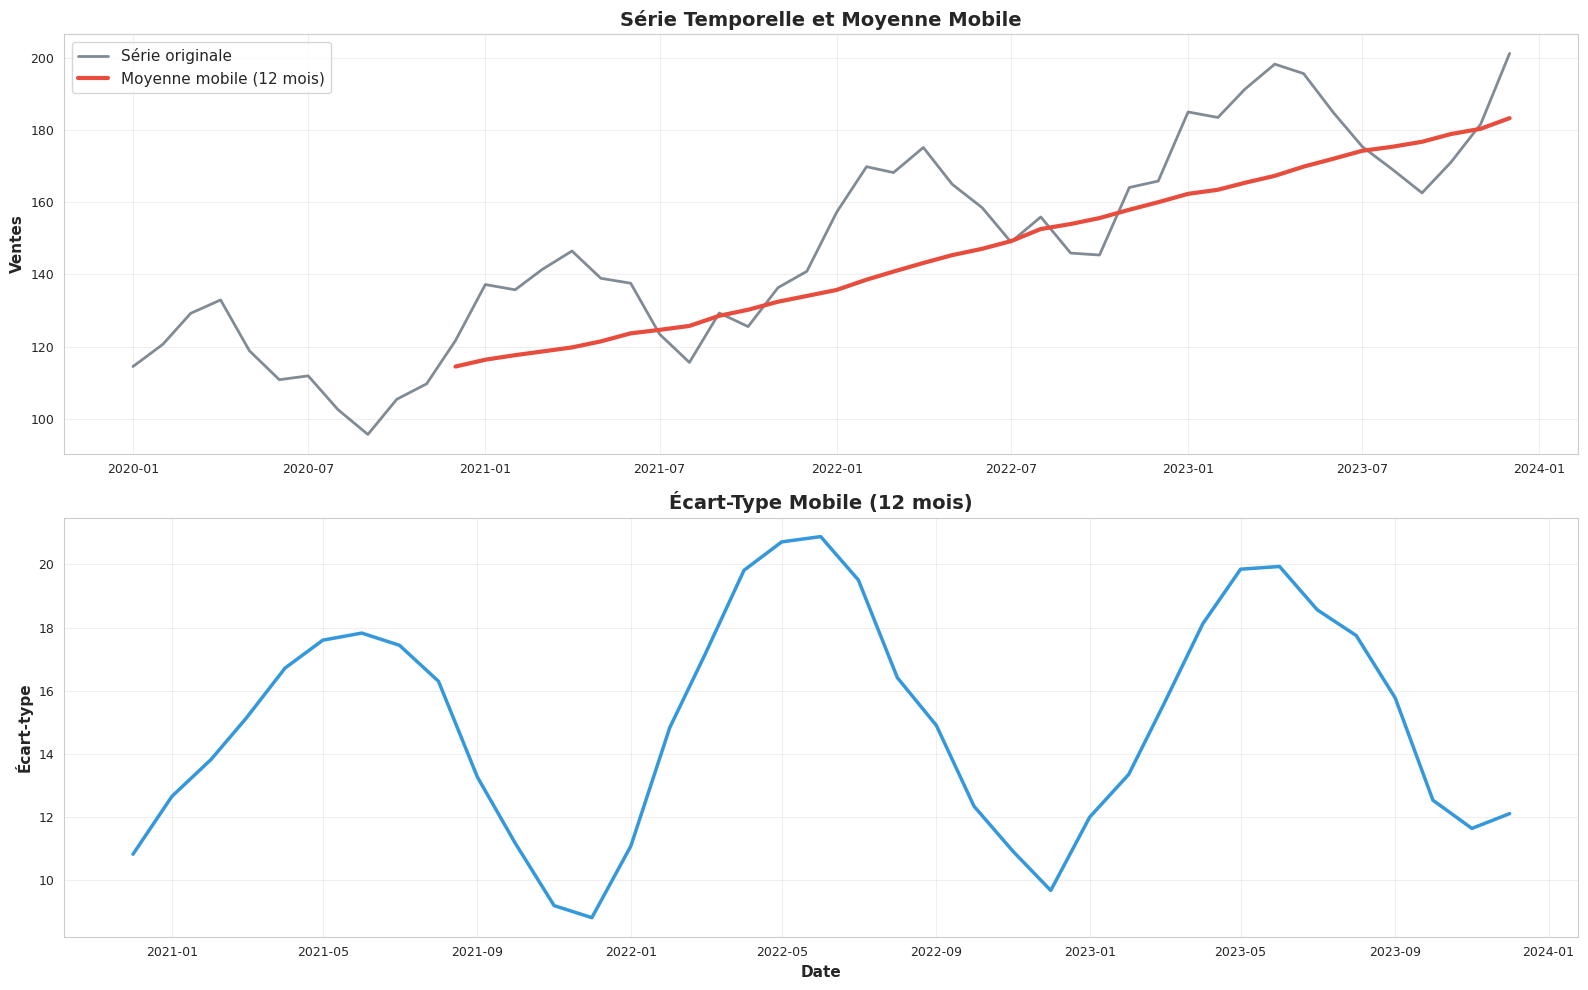


✓ Graphiques affichés

INTERPRÉTATION:
- Si la moyenne mobile est CROISSANTE → Série NON stationnaire
- Si la variance mobile est VARIABLE → Série NON stationnaire
- Pour notre série: tendance croissante visible → NON STATIONNAIRE


In [41]:
"""
Analyse visuelle de la stationnarité via moyenne et variance mobiles
"""
print("\n" + "=" * 70)
print("ANALYSE DE LA STATIONNARITÉ: MOYENNE ET VARIANCE MOBILES")
print("=" * 70)

# Calcul de la moyenne et variance mobiles
window = 12
rolling_mean = train['ventes'].rolling(window=window).mean()
rolling_std = train['ventes'].rolling(window=window).std()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Graphique 1: Série avec moyenne mobile
axes[0].plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
             label='Série originale', alpha=0.6)
axes[0].plot(rolling_mean.index, rolling_mean, linewidth=3, color='#E74C3C',
             label=f'Moyenne mobile ({window} mois)')
axes[0].set_title('Série Temporelle et Moyenne Mobile', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ventes', fontsize=11, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Graphique 2: Variance mobile
axes[1].plot(rolling_std.index, rolling_std, linewidth=2.5, color='#3498DB')
axes[1].set_title(f'Écart-Type Mobile ({window} mois)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Écart-type', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Graphiques affichés")
print("\nINTERPRÉTATION:")
print("- Si la moyenne mobile est CROISSANTE → Série NON stationnaire")
print("- Si la variance mobile est VARIABLE → Série NON stationnaire")
print("- Pour notre série: tendance croissante visible → NON STATIONNAIRE")


MODÈLE 4: AUTORÉGRESSIF (AR)

📚 PRINCIPE:
Utilise les valeurs passées de la série pour prédire la valeur future.
Formule: Y(t) = c + φ₁Y(t-1) + φ₂Y(t-2) + ... + φₚY(t-p) + ε(t)
où p est l'ordre du modèle AR, φ sont les coefficients et ε est le bruit blanc.
                               SARIMAX Results                                
Dep. Variable:                 ventes   No. Observations:                   47
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -162.745
Date:                Mon, 27 Oct 2025   AIC                            339.491
Time:                        16:43:44   BIC                            352.442
Sample:                    02-01-2020   HQIC                           344.364
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

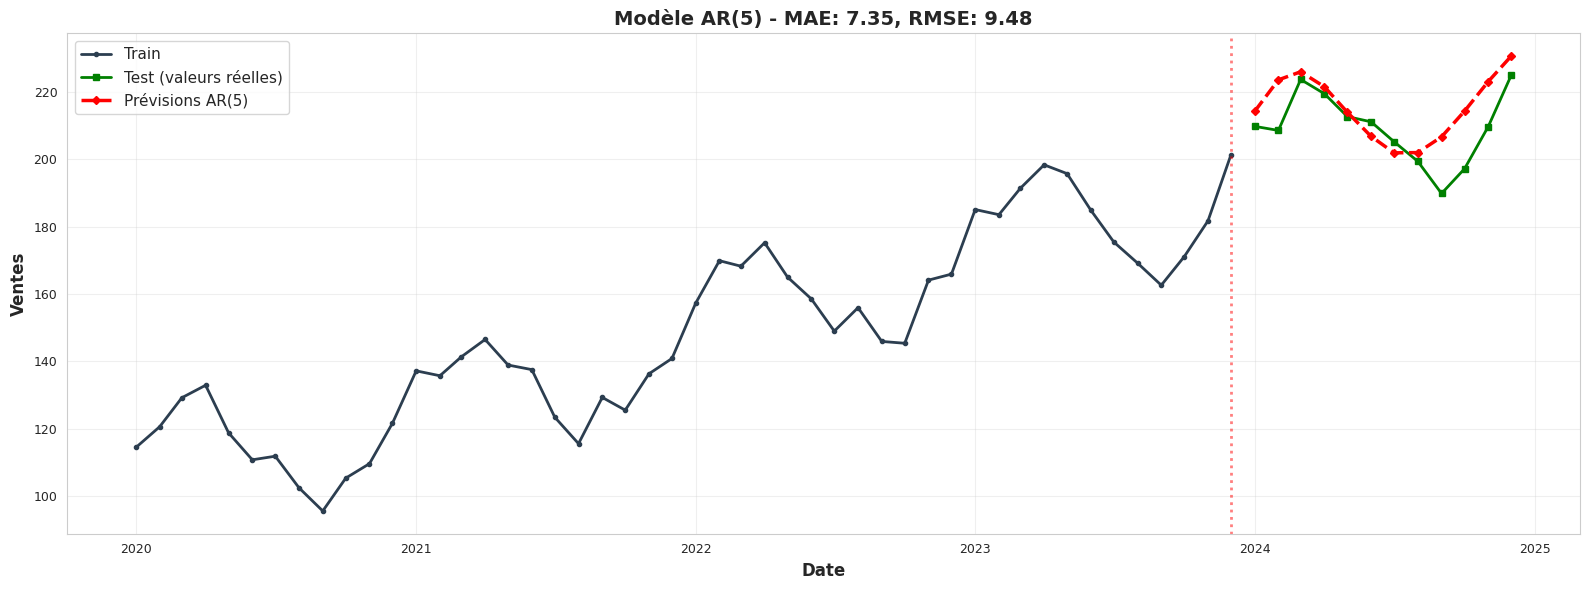

In [42]:
"""
MODÈLE 4: Modèle AR (AutoRégressif)
Capture les dépendances linéaires entre une observation et ses observations passées.
"""
print("\n" + "=" * 70)
print("MODÈLE 4: AUTORÉGRESSIF (AR)")
print("=" * 70)

print("\n📚 PRINCIPE:")
print("Utilise les valeurs passées de la série pour prédire la valeur future.")
print("Formule: Y(t) = c + φ₁Y(t-1) + φ₂Y(t-2) + ... + φₚY(t-p) + ε(t)")
print("où p est l'ordre du modèle AR, φ sont les coefficients et ε est le bruit blanc.")

# Détermination de l'ordre p (via PACF de la série stationnarisée ou intuition)
# Pour l'exemple, on peut commencer avec un ordre simple, e.g., p=5
p_order = 5

# Entraînement du modèle AR
# Note: Les modèles AR/ARMA/ARIMA de statsmodels s'attendent à une série stationnaire.
# Utiliser la série différenciée d=1 car elle a montré des signes de stationnarité dans les tests ADF/KPSS.
try:
    ar_model = ARIMA(train_diff1, order=(p_order, 0, 0)).fit()
    print(ar_model.summary())

    # Prévisions sur la série différenciée
    ar_forecast_diff = ar_model.forecast(steps=len(test))

    # Revenir à l'échelle originale
    # La prévision AR est pour la série différenciée (Y(t) - Y(t-1)).
    # Pour obtenir Y(t), on fait Y(t) = Y(t-1) + ∇Y(t).
    # On a besoin de la dernière valeur du TRAIN original pour commencer.
    last_train_value = train['ventes'].iloc[-1]
    ar_forecast = np.zeros(len(test))
    ar_forecast[0] = last_train_value + ar_forecast_diff.iloc[0]

    for i in range(1, len(test)):
        ar_forecast[i] = ar_forecast[i-1] + ar_forecast_diff.iloc[i]

    # Convertir les prévisions en Series avec l'index du test
    ar_forecast = pd.Series(ar_forecast, index=test.index)


    # Métriques
    mae_ar = mean_absolute_error(test['ventes'], ar_forecast)
    rmse_ar = np.sqrt(mean_squared_error(test['ventes'], ar_forecast))
    mape_ar = np.mean(np.abs((test['ventes'] - ar_forecast) / test['ventes'])) * 100

    print(f"\n--- Résultats AR(p={p_order}) ---")
    print(f"MAE:  {mae_ar:.2f}")
    print(f"RMSE: {rmse_ar:.2f}")
    print(f"MAPE: {mape_ar:.2f}%")

    # Visualisation
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
            label='Train', marker='o', markersize=3)
    ax.plot(test.index, test['ventes'], linewidth=2, color='green',
            label='Test (valeurs réelles)', marker='s', markersize=4)
    ax.plot(test.index, ar_forecast, linewidth=2.5, color='red',
            linestyle='--', label=f'Prévisions AR({p_order})', marker='D', markersize=4)
    ax.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
    ax.set_title(f'Modèle AR({p_order}) - MAE: {mae_ar:.2f}, RMSE: {rmse_ar:.2f}',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n❌ Erreur lors de l'entraînement ou de la prévision du modèle AR: {e}")
    print("   Vérifiez l'ordre p et la stationnarité de la série utilisée.")


MODÈLE 5: ARIMA

📚 PRINCIPE:
ARIMA(p, d, q) = AR(p) + I(d) + MA(q)
  - AR(p): Composante autorégressive d'ordre p
  - I(d): Intégration d'ordre d (différenciation)
  - MA(q): Composante moyenne mobile d'ordre q

Paramètres ARIMA: (5, 1, 5)
                               SARIMAX Results                                
Dep. Variable:                 ventes   No. Observations:                   48
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -155.547
Date:                Mon, 27 Oct 2025   AIC                            333.093
Time:                        16:43:54   BIC                            353.445
Sample:                    01-01-2020   HQIC                           340.752
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

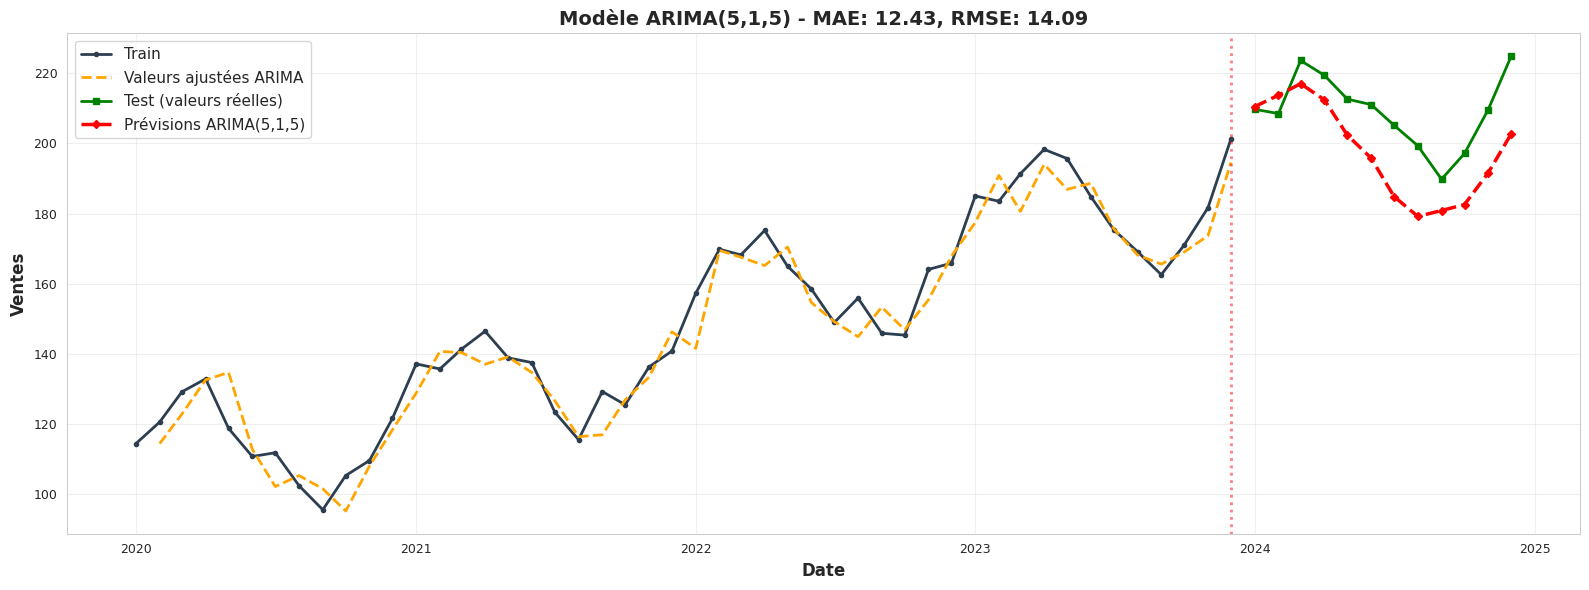

In [43]:
"""
MODÈLE 5: Modèle ARIMA (AutoRegressive Integrated Moving Average)
Combine les modèles AR et MA, et utilise la différenciation pour la stationnarité.
"""
print("\n" + "=" * 70)
print("MODÈLE 5: ARIMA")
print("=" * 70)

print("\n📚 PRINCIPE:")
print("ARIMA(p, d, q) = AR(p) + I(d) + MA(q)")
print("  - AR(p): Composante autorégressive d'ordre p")
print("  - I(d): Intégration d'ordre d (différenciation)")
print("  - MA(q): Composante moyenne mobile d'ordre q")

# Détermination des ordres p, d, q
# d = ordre de différenciation pour rendre la série stationnaire (on a vu d=1 était suffisant)
# p = ordre AR (via PACF de la série différenciée)
# q = ordre MA (via ACF de la série différenciée)

# Pour l'exemple, utilisons d=1 et des ordres p et q simples (e.g., p=5, q=5)
p_order_arima = 5
d_order_arima = 1
q_order_arima = 5

print(f"\nParamètres ARIMA: ({p_order_arima}, {d_order_arima}, {q_order_arima})")

# Entraînement du modèle ARIMA
try:
    arima_model = ARIMA(train['ventes'], order=(p_order_arima, d_order_arima, q_order_arima)).fit()
    print(arima_model.summary())

    # Prévisions
    arima_forecast = arima_model.forecast(steps=len(test))
    arima_fitted = arima_model.fittedvalues[d_order_arima:] # Exclure les valeurs NaN dues à la différenciation

    # Métriques
    mae_arima = mean_absolute_error(test['ventes'], arima_forecast)
    rmse_arima = np.sqrt(mean_squared_error(test['ventes'], arima_forecast))
    mape_arima = np.mean(np.abs((test['ventes'] - arima_forecast) / test['ventes'])) * 100

    print(f"\n--- Résultats ARIMA({p_order_arima},{d_order_arima},{q_order_arima}) ---")
    print(f"MAE:  {mae_arima:.2f}")
    print(f"RMSE: {rmse_arima:.2f}")
    print(f"MAPE: {mape_arima:.2f}%")

    # Visualisation
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
            label='Train', marker='o', markersize=3)
    ax.plot(arima_fitted.index, arima_fitted, linewidth=2, color='orange',
            linestyle='--', label='Valeurs ajustées ARIMA')
    ax.plot(test.index, test['ventes'], linewidth=2, color='green',
            label='Test (valeurs réelles)', marker='s', markersize=4)
    ax.plot(test.index, arima_forecast, linewidth=2.5, color='red',
            linestyle='--', label=f'Prévisions ARIMA({p_order_arima},{d_order_arima},{q_order_arima})', marker='D', markersize=4)
    ax.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
    ax.set_title(f'Modèle ARIMA({p_order_arima},{d_order_arima},{q_order_arima}) - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n❌ Erreur lors de l'entraînement ou de la prévision du modèle ARIMA: {e}")
    print("   Vérifiez les ordres (p, d, q).")


ANALYSE DES AUTOCORRÉLATIONS (ACF & PACF)

📚 RAPPEL THÉORIQUE:

ACF (AutoCorrelation Function):
  - Mesure la corrélation entre Y(t) et Y(t-k)
  - Décroissance lente → Série NON stationnaire
  - Pics périodiques → Présence de saisonnalité
  - Aide à identifier l'ordre q du modèle MA

PACF (Partial AutoCorrelation Function):
  - Corrélation entre Y(t) et Y(t-k) après élimination de l'effet des lags intermédiaires
  - Aide à identifier l'ordre p du modèle AR


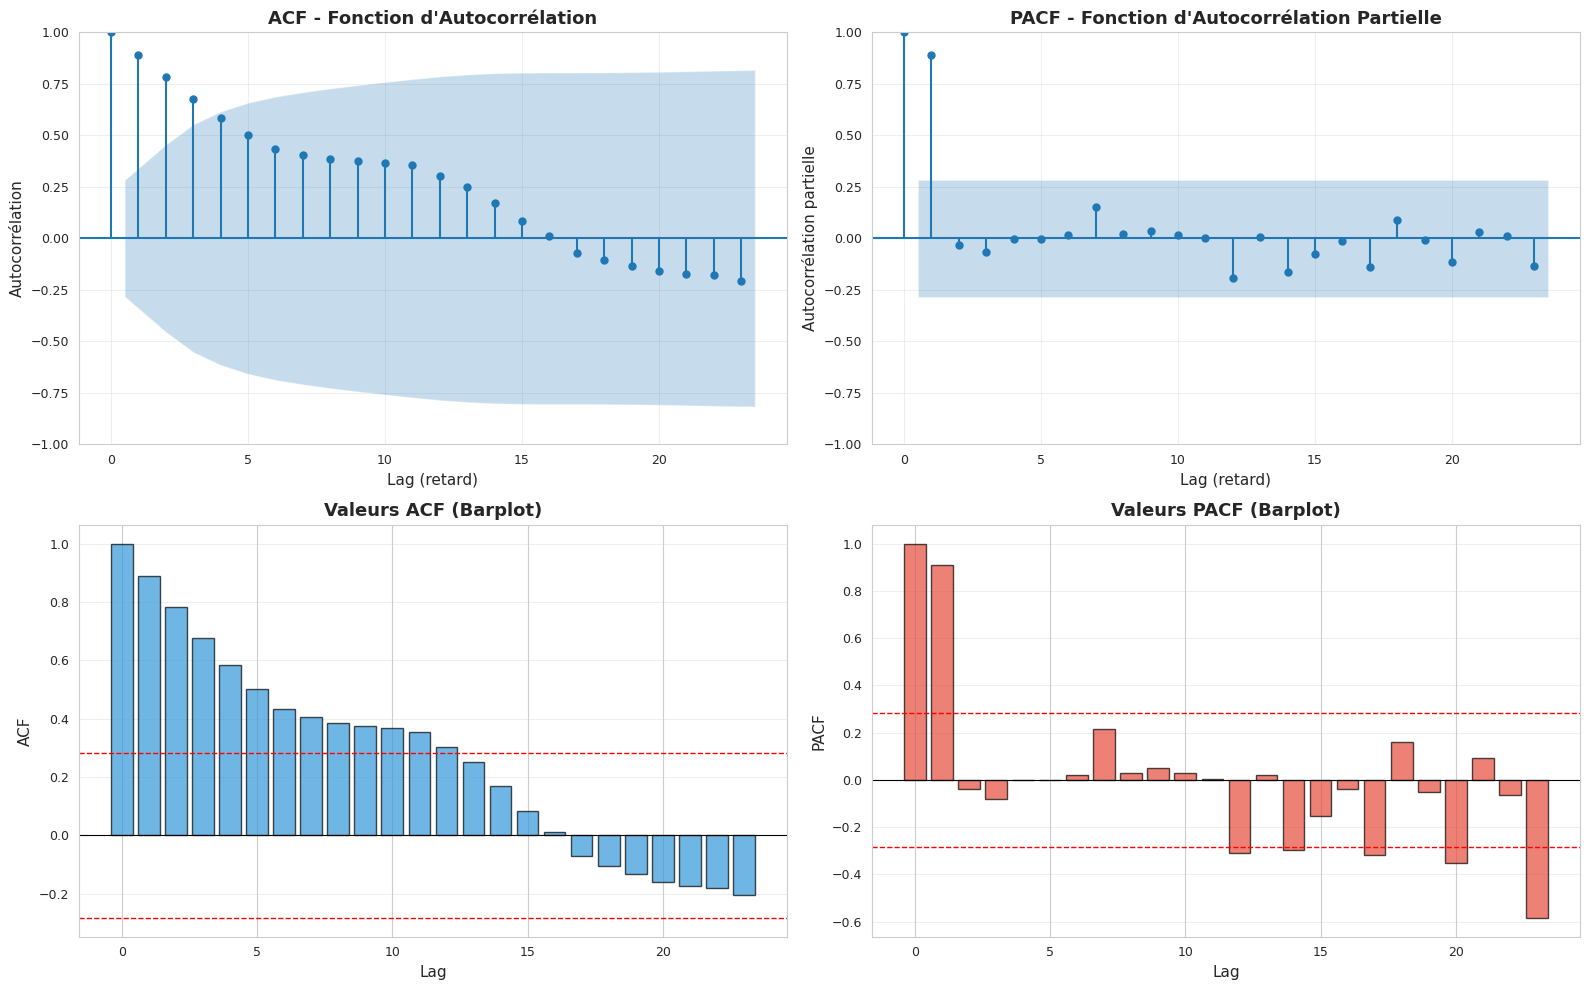


✓ Graphiques ACF/PACF affichés

INTERPRÉTATION:
- ACF décroît LENTEMENT → Confirme la NON-stationnarité
- Pics réguliers tous les 12 lags → Confirme la SAISONNALITÉ (P=12)
- Lignes rouges en pointillés = Intervalles de confiance à 95%

--- Premières valeurs ACF ---
Lag 0: 1.0000
Lag 1: 0.8893
Lag 2: 0.7839
Lag 3: 0.6771
Lag 4: 0.5831
Lag 5: 0.5006
Lag 6: 0.4325
Lag 7: 0.4055
Lag 8: 0.3854
Lag 9: 0.3757
Lag 10: 0.3668
Lag 11: 0.3557
Lag 12: 0.3022


In [44]:
"""
Analyse des autocorrélations pour identifier les patterns
"""
print("\n" + "=" * 70)
print("ANALYSE DES AUTOCORRÉLATIONS (ACF & PACF)")
print("=" * 70)

print("\n📚 RAPPEL THÉORIQUE:")
print("\nACF (AutoCorrelation Function):")
print("  - Mesure la corrélation entre Y(t) et Y(t-k)")
print("  - Décroissance lente → Série NON stationnaire")
print("  - Pics périodiques → Présence de saisonnalité")
print("  - Aide à identifier l'ordre q du modèle MA")

print("\nPACF (Partial AutoCorrelation Function):")
print("  - Corrélation entre Y(t) et Y(t-k) après élimination de l'effet des lags intermédiaires")
print("  - Aide à identifier l'ordre p du modèle AR")

# Calcul des ACF et PACF
lags_max = 23 # Reduced lags_max to be less than 50% of sample size (48 / 2 = 24)
acf_values = acf(train['ventes'], nlags=lags_max)
pacf_values = pacf(train['ventes'], nlags=lags_max)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF graphique 1
plot_acf(train['ventes'], lags=lags_max, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('ACF - Fonction d\'Autocorrélation', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Lag (retard)', fontsize=11)
axes[0, 0].set_ylabel('Autocorrélation', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# PACF graphique 2
plot_pacf(train['ventes'], lags=lags_max, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('PACF - Fonction d\'Autocorrélation Partielle', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Lag (retard)', fontsize=11)
axes[0, 1].set_ylabel('Autocorrélation partielle', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Valeurs numériques ACF
axes[1, 0].bar(range(len(acf_values)), acf_values, color='#3498DB', alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].axhline(y=1.96/np.sqrt(len(train)), color='red', linestyle='--', linewidth=1)
axes[1, 0].axhline(y=-1.96/np.sqrt(len(train)), color='red', linestyle='--', linewidth=1)
axes[1, 0].set_title('Valeurs ACF (Barplot)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Lag', fontsize=11)
axes[1, 0].set_ylabel('ACF', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Valeurs numériques PACF
axes[1, 1].bar(range(len(pacf_values)), pacf_values, color='#E74C3C', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].axhline(y=1.96/np.sqrt(len(train)), color='red', linestyle='--', linewidth=1)
axes[1, 1].axhline(y=-1.96/np.sqrt(len(train)), color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Valeurs PACF (Barplot)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=11)
axes[1, 1].set_ylabel('PACF', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Graphiques ACF/PACF affichés")
print("\nINTERPRÉTATION:")
print("- ACF décroît LENTEMENT → Confirme la NON-stationnarité")
print("- Pics réguliers tous les 12 lags → Confirme la SAISONNALITÉ (P=12)")
print("- Lignes rouges en pointillés = Intervalles de confiance à 95%")

# Affichage des premières valeurs
print("\n--- Premières valeurs ACF ---")
for i in range(min(13, len(acf_values))):
    print(f"Lag {i}: {acf_values[i]:.4f}")


DÉCOMPOSITION SAISONNIÈRE (SEASONAL DECOMPOSE)

📚 RAPPEL THÉORIQUE:

Modèle ADDITIF: Y(t) = T(t) + S(t) + R(t)
  - T(t): Tendance (mouvement à long terme)
  - S(t): Saisonnalité (variations périodiques)
  - R(t): Résidus (variations aléatoires)

Modèle MULTIPLICATIF: Y(t) = T(t) × S(t) × R(t)
  - Utilisé quand l'amplitude de la saisonnalité change avec le niveau

--- Statistiques des composantes ---

Tendance:
  Min: 115.43, Max: 181.86
  Moyenne: 147.46

Saisonnalité:
  Min: -17.28, Max: 19.16
  Amplitude: 36.44

Résidus:
  Moyenne: 0.16
  Écart-type: 3.46


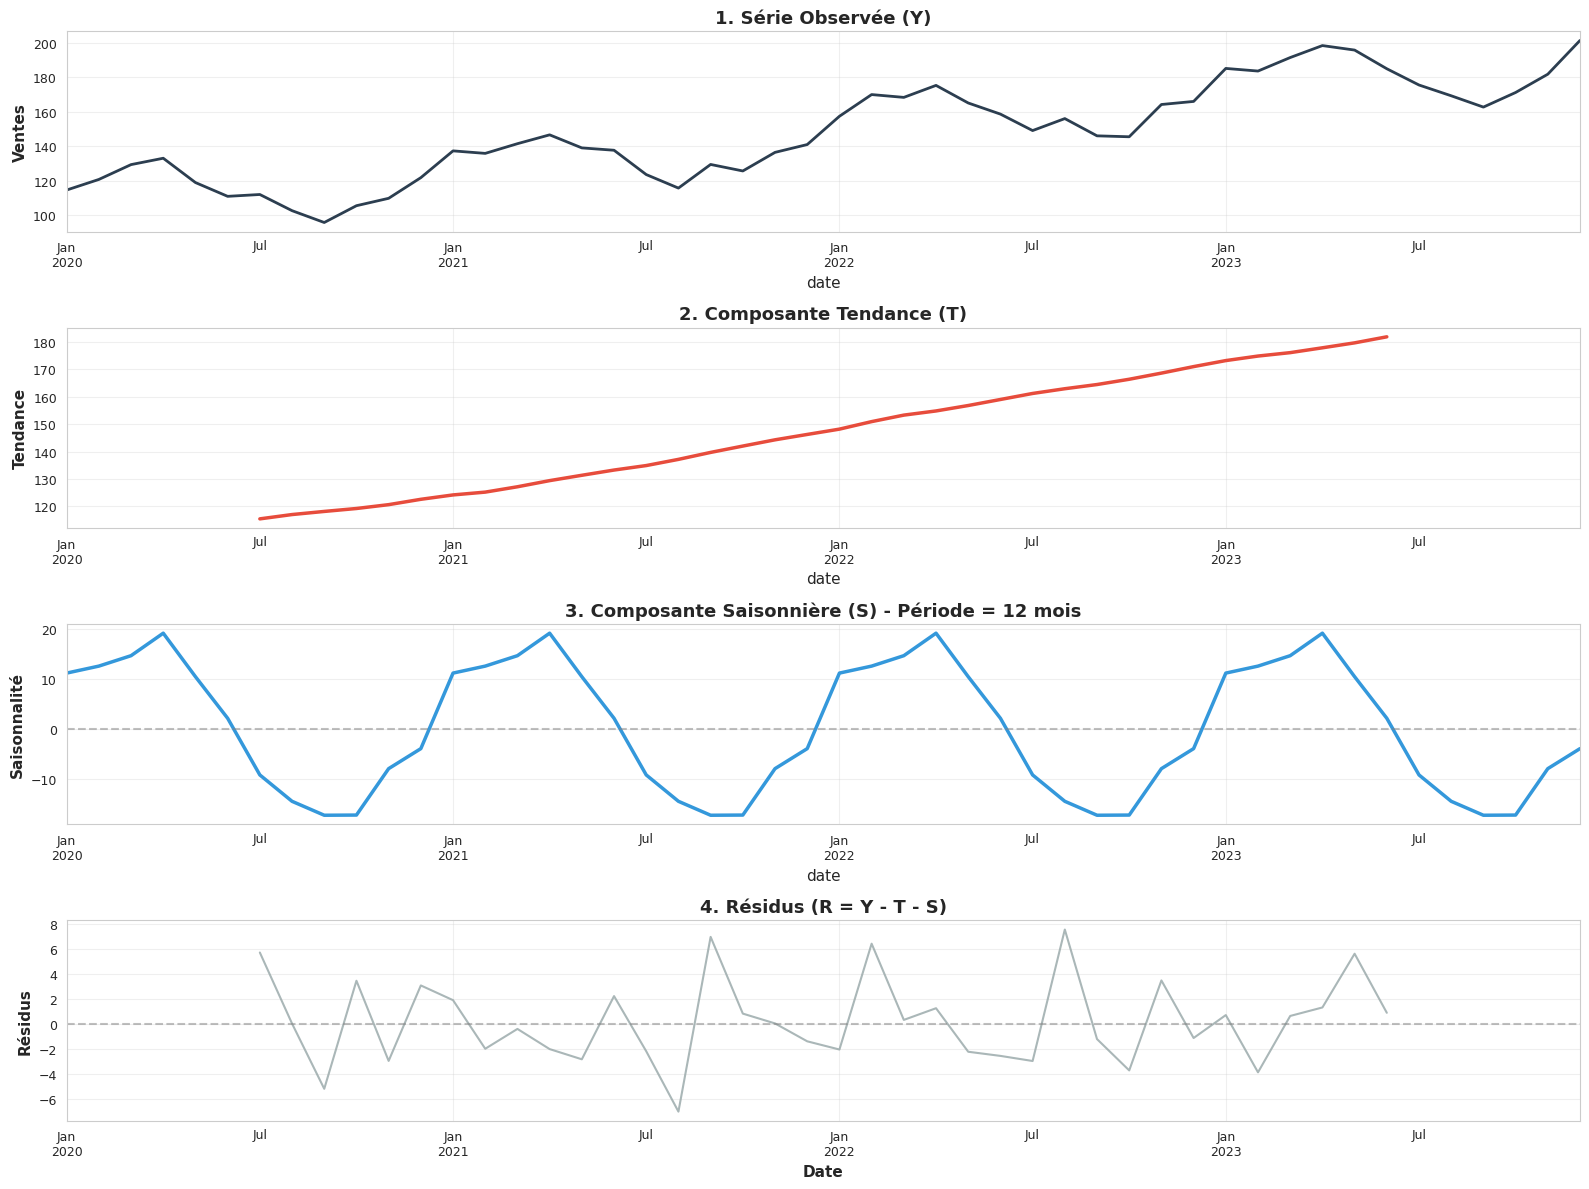


✓ Décomposition effectuée et visualisée

--- Pattern saisonnier moyen (12 mois) ---
Jan: +11.17
Fév: +12.57
Mar: +14.66
Avr: +19.16
Mai: +10.45
Juin: +2.13
Juil: -9.21
Août: -14.49
Sep: -17.28
Oct: -17.25
Nov: -7.95
Déc: -3.95


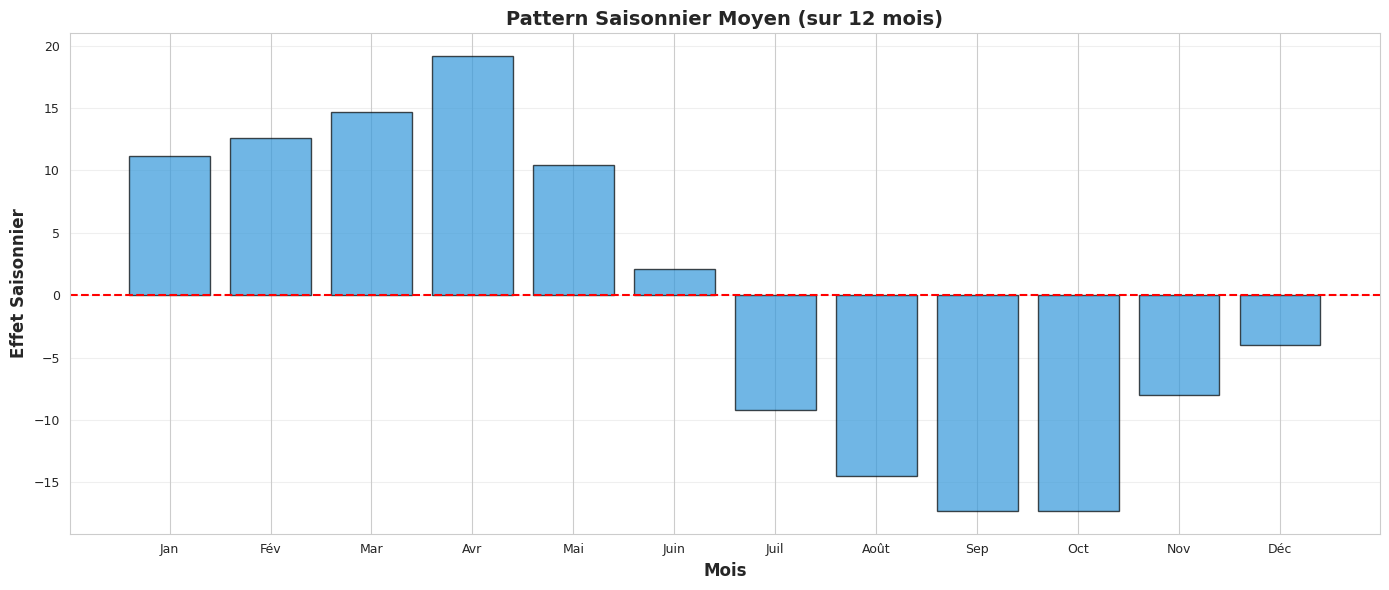

In [45]:
"""
Décomposition de la série en: Tendance + Saisonnalité + Résidus
"""
print("\n" + "=" * 70)
print("DÉCOMPOSITION SAISONNIÈRE (SEASONAL DECOMPOSE)")
print("=" * 70)

print("\n📚 RAPPEL THÉORIQUE:")
print("\nModèle ADDITIF: Y(t) = T(t) + S(t) + R(t)")
print("  - T(t): Tendance (mouvement à long terme)")
print("  - S(t): Saisonnalité (variations périodiques)")
print("  - R(t): Résidus (variations aléatoires)")
print("\nModèle MULTIPLICATIF: Y(t) = T(t) × S(t) × R(t)")
print("  - Utilisé quand l'amplitude de la saisonnalité change avec le niveau")

# Décomposition additive
decomposition = seasonal_decompose(train['ventes'], model='additive', period=12)

# Extraction des composantes
trend_comp = decomposition.trend
seasonal_comp = decomposition.seasonal
residual_comp = decomposition.resid

print("\n--- Statistiques des composantes ---")
print(f"\nTendance:")
print(f"  Min: {trend_comp.min():.2f}, Max: {trend_comp.max():.2f}")
print(f"  Moyenne: {trend_comp.mean():.2f}")

print(f"\nSaisonnalité:")
print(f"  Min: {seasonal_comp.min():.2f}, Max: {seasonal_comp.max():.2f}")
print(f"  Amplitude: {seasonal_comp.max() - seasonal_comp.min():.2f}")

print(f"\nRésidus:")
print(f"  Moyenne: {residual_comp.mean():.2f}")
print(f"  Écart-type: {residual_comp.std():.2f}")

# Visualisation
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Série observée
decomposition.observed.plot(ax=axes[0], color='#2C3E50', linewidth=2)
axes[0].set_title('1. Série Observée (Y)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Ventes', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Tendance
decomposition.trend.plot(ax=axes[1], color='#E74C3C', linewidth=2.5)
axes[1].set_title('2. Composante Tendance (T)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Tendance', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Saisonnalité
decomposition.seasonal.plot(ax=axes[2], color='#3498DB', linewidth=2.5)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('3. Composante Saisonnière (S) - Période = 12 mois', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Saisonnalité', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Résidus
decomposition.resid.plot(ax=axes[3], color='#95A5A6', linewidth=1.5, alpha=0.8)
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].set_title('4. Résidus (R = Y - T - S)', fontsize=13, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[3].set_ylabel('Résidus', fontsize=11, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Décomposition effectuée et visualisée")

# Pattern saisonnier moyen
seasonal_pattern = seasonal_comp[:12]
print("\n--- Pattern saisonnier moyen (12 mois) ---")
mois_noms = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin',
             'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
for i, (mois, val) in enumerate(zip(mois_noms, seasonal_pattern)):
    print(f"{mois}: {val:+.2f}")

# Visualisation du pattern saisonnier
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(range(1, 13), seasonal_pattern, color='#3498DB', alpha=0.7, edgecolor='black')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax.set_title('Pattern Saisonnier Moyen (sur 12 mois)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mois', fontsize=12, fontweight='bold')
ax.set_ylabel('Effet Saisonnier', fontsize=12, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(mois_noms)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



ANALYSE DES RÉSIDUS DE LA DÉCOMPOSITION

📊 Statistiques des résidus:
Moyenne: 0.1644 (devrait être ≈ 0)
Écart-type: 3.4649
Min: -7.0282
Max: 7.5168

--- Test de normalité des résidus (Shapiro-Wilk) ---
Statistique: 0.9680
P-value: 0.3734
✓ Les résidus suivent une distribution NORMALE

--- Test de Ljung-Box (autocorrélation des résidus) ---
H0: Les résidus sont du bruit blanc (pas d'autocorrélation)
      lb_stat  lb_pvalue
10  10.757547   0.376717
20  38.241917   0.008272
✓ Les résidus sont du BRUIT BLANC (pas d'autocorrélation)


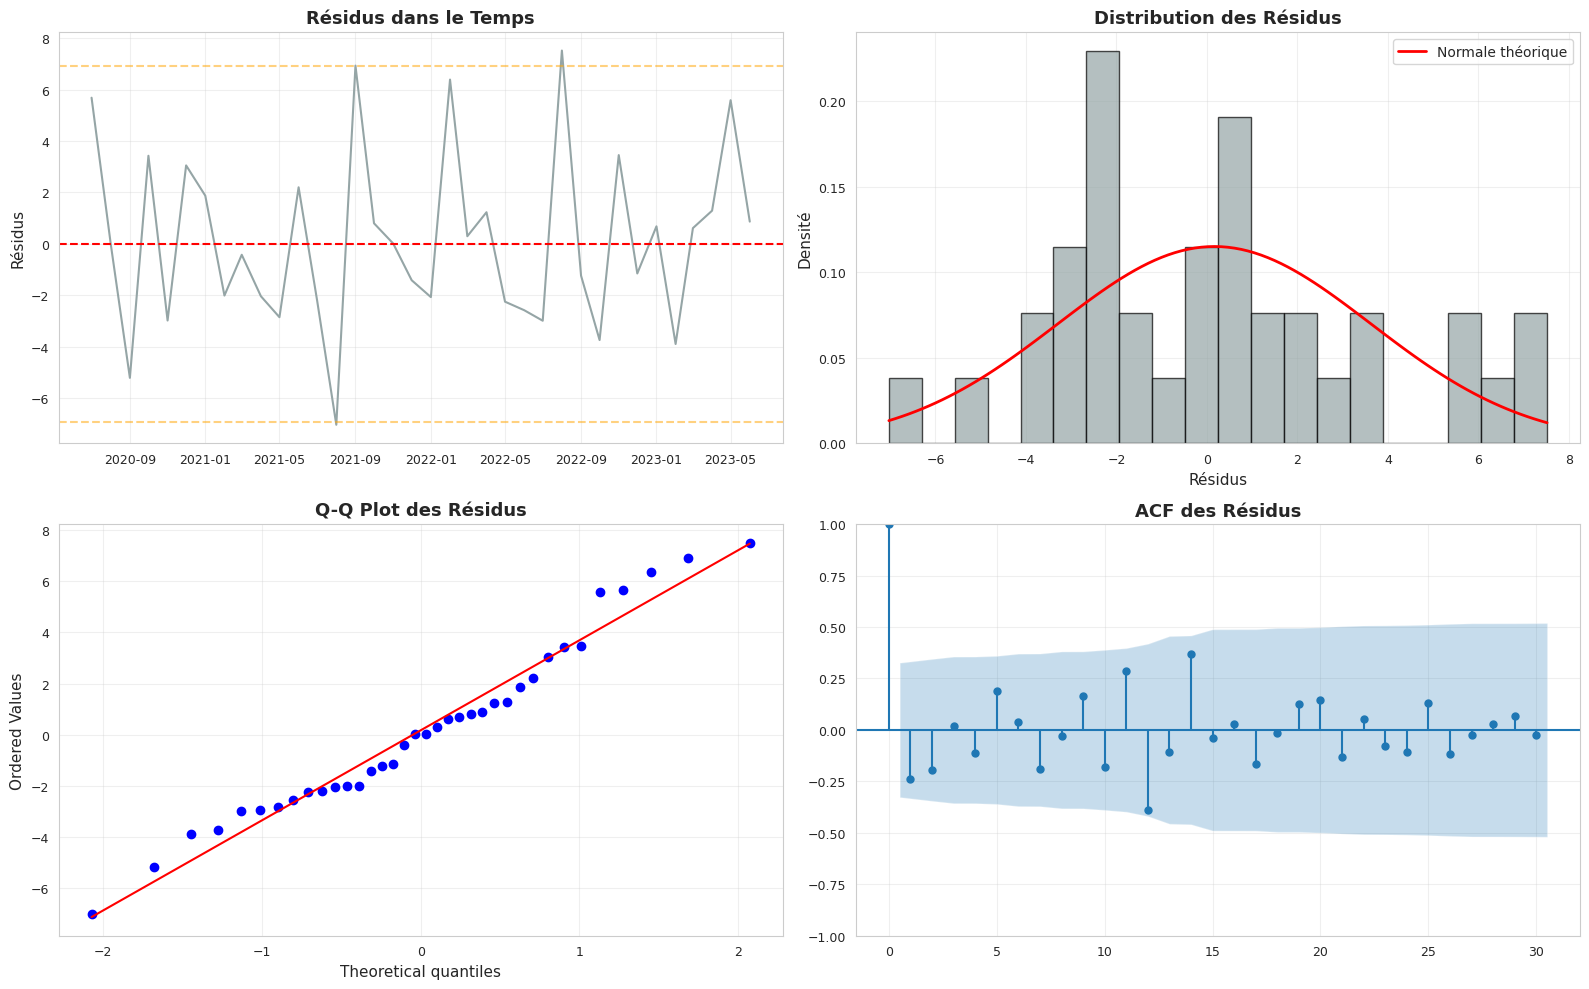


✓ Analyse des résidus terminée


In [46]:
"""
Vérification que les résidus sont du bruit blanc
"""
print("\n" + "=" * 70)
print("ANALYSE DES RÉSIDUS DE LA DÉCOMPOSITION")
print("=" * 70)

# Supprimer les NaN
residuals_clean = residual_comp.dropna()

print("\n📊 Statistiques des résidus:")
print(f"Moyenne: {residuals_clean.mean():.4f} (devrait être ≈ 0)")
print(f"Écart-type: {residuals_clean.std():.4f}")
print(f"Min: {residuals_clean.min():.4f}")
print(f"Max: {residuals_clean.max():.4f}")

# Tests sur les résidus
print("\n--- Test de normalité des résidus (Shapiro-Wilk) ---")
shapiro_resid = stats.shapiro(residuals_clean)
print(f"Statistique: {shapiro_resid[0]:.4f}")
print(f"P-value: {shapiro_resid[1]:.4f}")
if shapiro_resid[1] > 0.05:
    print("✓ Les résidus suivent une distribution NORMALE")
else:
    print("✗ Les résidus ne suivent PAS une distribution normale")

# Test de Ljung-Box pour l'autocorrélation des résidus
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box = acorr_ljungbox(residuals_clean, lags=[10, 20], return_df=True)
print("\n--- Test de Ljung-Box (autocorrélation des résidus) ---")
print("H0: Les résidus sont du bruit blanc (pas d'autocorrélation)")
print(ljung_box)
if ljung_box['lb_pvalue'].iloc[0] > 0.05:
    print("✓ Les résidus sont du BRUIT BLANC (pas d'autocorrélation)")
else:
    print("✗ Les résidus présentent de l'autocorrélation")

# Visualisation des résidus
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Série temporelle des résidus
axes[0, 0].plot(residuals_clean.index, residuals_clean, linewidth=1.5, color='#95A5A6')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[0, 0].axhline(y=2*residuals_clean.std(), color='orange', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=-2*residuals_clean.std(), color='orange', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Résidus dans le Temps', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Résidus', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Histogramme
axes[0, 1].hist(residuals_clean, bins=20, density=True, alpha=0.7,
                color='#95A5A6', edgecolor='black')
x_hist = np.linspace(residuals_clean.min(), residuals_clean.max(), 100)
axes[0, 1].plot(x_hist, stats.norm.pdf(x_hist, residuals_clean.mean(),
                residuals_clean.std()), 'r-', linewidth=2, label='Normale théorique')
axes[0, 1].set_title('Distribution des Résidus', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Résidus', fontsize=11)
axes[0, 1].set_ylabel('Densité', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals_clean, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot des Résidus', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF des résidus
plot_acf(residuals_clean, lags=30, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF des Résidus', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analyse des résidus terminée")


MODÈLE 6: SARIMA

📚 PRINCIPE:
SARIMA(p, d, q)(P, D, Q)s
  - (p, d, q): Ordres non-saisonniers (AR, Intégration, MA)
  - (P, D, Q): Ordres saisonniers (AR saisonnier, Intégration saisonnière, MA saisonnier)
  - s: Période saisonnière (ici, s=12)

Paramètres SARIMA: (1, 1, 1)(1, 1, 1)12
                                     SARIMAX Results                                      
Dep. Variable:                             ventes   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -113.487
Date:                            Mon, 27 Oct 2025   AIC                            236.973
Time:                                    16:44:28   BIC                            244.750
Sample:                                01-01-2020   HQIC                           239.658
                                     - 12-01-2023                                         
Covariance Type:                              opg                           

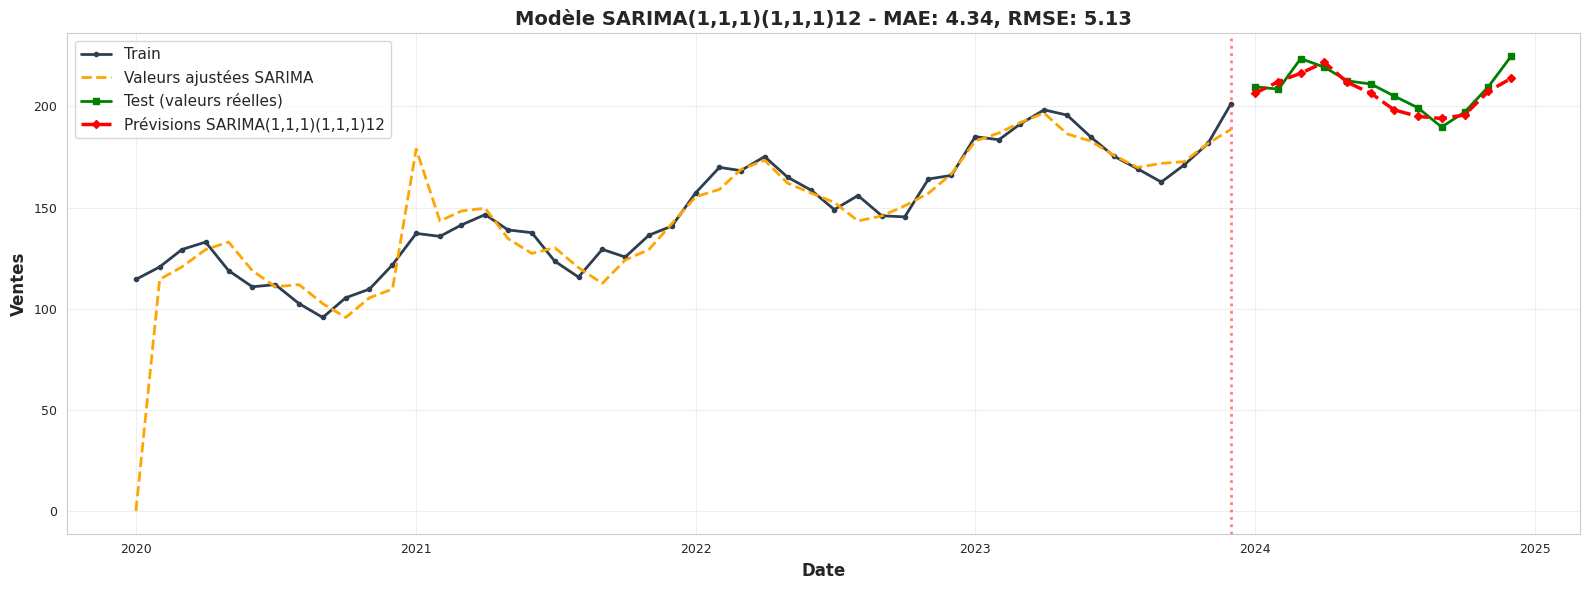

In [47]:
"""
MODÈLE 6: Modèle SARIMA (Seasonal AutoRegressive Integrated Moving Average)
Combine les modèles ARIMA avec une composante saisonnière.
"""
print("\n" + "=" * 70)
print("MODÈLE 6: SARIMA")
print("=" * 70)

print("\n📚 PRINCIPE:")
print("SARIMA(p, d, q)(P, D, Q)s")
print("  - (p, d, q): Ordres non-saisonniers (AR, Intégration, MA)")
print("  - (P, D, Q): Ordres saisonniers (AR saisonnier, Intégration saisonnière, MA saisonnier)")
print("  - s: Période saisonnière (ici, s=12)")

# Détermination des ordres (p, d, q) et (P, D, Q)s
# d = ordre de différenciation non-saisonnier (on a vu d=1 est utile)
# D = ordre de différenciation saisonnière (on a vu D=1 est utile pour la saisonnalité)
# s = période saisonnière (s=12)
# p, q, P, Q peuvent être identifiés à partir des ACF/PACF des séries différenciées,
# ou par optimisation (recherche de grille).

# Pour l'exemple, utilisons des ordres simples basés sur les analyses précédentes (d=1, D=1, s=12)
# et des ordres AR/MA/saisonniers initiaux (par exemple, p=1, q=1, P=1, Q=1)
p_order_sarima = 1
d_order_sarima = 1
q_order_sarima = 1
P_order_sarima = 1
D_order_sarima = 1
Q_order_sarima = 1
s_period = 12

print(f"\nParamètres SARIMA: ({p_order_sarima}, {d_order_sarima}, {q_order_sarima})({P_order_sarima}, {D_order_sarima}, {Q_order_sarima}){s_period}")

# Entraînement du modèle SARIMA
try:
    sarima_model = SARIMAX(train['ventes'],
                           order=(p_order_sarima, d_order_sarima, q_order_sarima),
                           seasonal_order=(P_order_sarima, D_order_sarima, Q_order_sarima, s_period)).fit(disp=False) # disp=False pour éviter l'affichage détaillé pendant l'entraînement

    print(sarima_model.summary())

    # Prévisions
    sarima_forecast = sarima_model.forecast(steps=len(test))
    sarima_fitted = sarima_model.fittedvalues

    # Métriques
    mae_sarima = mean_absolute_error(test['ventes'], sarima_forecast)
    rmse_sarima = np.sqrt(mean_squared_error(test['ventes'], sarima_forecast))
    mape_sarima = np.mean(np.abs((test['ventes'] - sarima_forecast) / test['ventes'])) * 100

    print(f"\n--- Résultats SARIMA({p_order_sarima},{d_order_sarima},{q_order_sarima})({P_order_sarima},{D_order_sarima},{Q_order_sarima}){s_period} ---")
    print(f"MAE:  {mae_sarima:.2f}")
    print(f"RMSE: {rmse_sarima:.2f}")
    print(f"MAPE: {mape_sarima:.2f}%")

    # Visualisation
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
            label='Train', marker='o', markersize=3)
    ax.plot(sarima_fitted.index, sarima_fitted, linewidth=2, color='orange',
            linestyle='--', label='Valeurs ajustées SARIMA')
    ax.plot(test.index, test['ventes'], linewidth=2, color='green',
            label='Test (valeurs réelles)', marker='s', markersize=4)
    ax.plot(test.index, sarima_forecast, linewidth=2.5, color='red',
            linestyle='--', label=f'Prévisions SARIMA({p_order_sarima},{d_order_sarima},{q_order_sarima})({P_order_sarima},{D_order_sarima},{Q_order_sarima}){s_period}', marker='D', markersize=4)
    ax.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
    ax.set_title(f'Modèle SARIMA({p_order_sarima},{d_order_sarima},{q_order_sarima})({P_order_sarima},{D_order_sarima},{Q_order_sarima}){s_period} - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n❌ Erreur lors de l'entraînement ou de la prévision du modèle SARIMA: {e}")
    print("   Vérifiez les ordres (p, d, q) et (P, D, Q, s).")


DIFFÉRENCIATION DE LA SÉRIE

📚 RAPPEL THÉORIQUE:
Différenciation d'ordre 1: ∇Y(t) = Y(t) - Y(t-1)
Différenciation saisonnière: ∇₁₂Y(t) = Y(t) - Y(t-12)
But: Éliminer la tendance et la saisonnalité


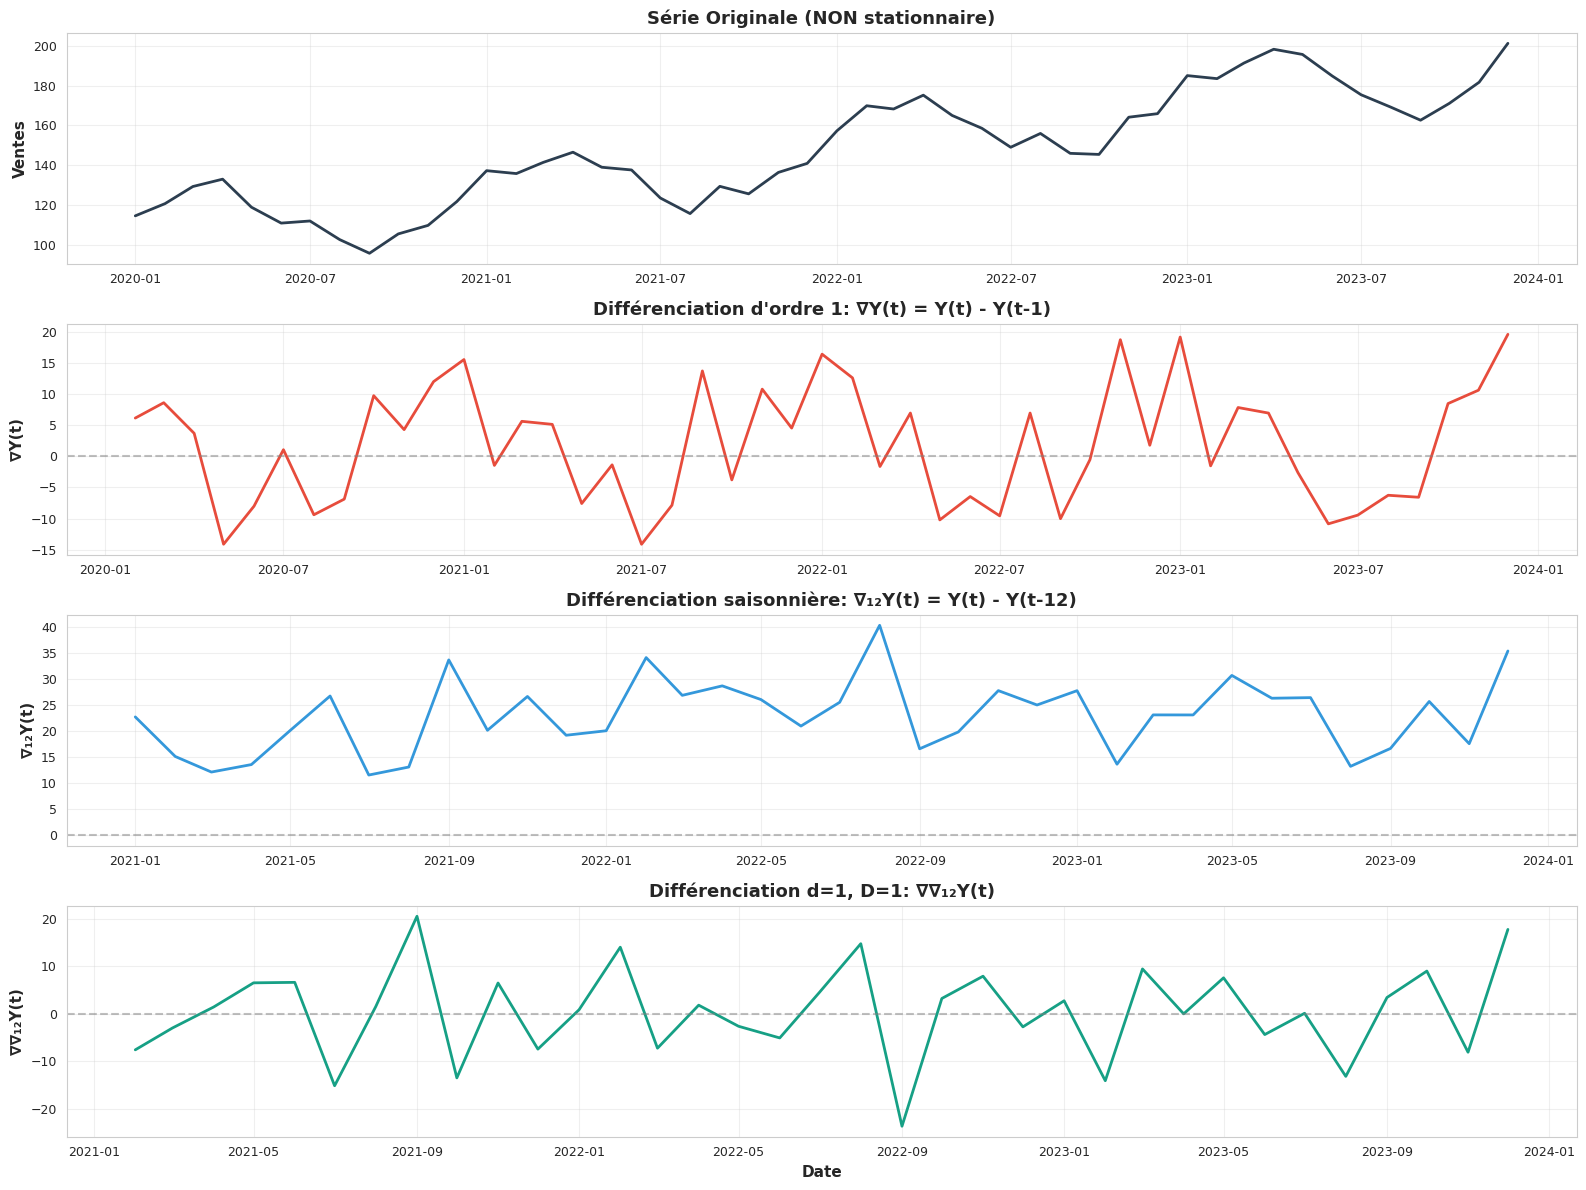


----------------------------------------------------------------------
TEST ADF SUR LES SÉRIES DIFFÉRENCIÉES
----------------------------------------------------------------------

           Série ADF Statistic P-value Stationnaire?
Série originale        1.2312  0.9962         ✗ NON
       Diff d=1       -4.7696  0.0001         ✓ OUI
Diff D=1 (s=12)       -5.3284  0.0000         ✓ OUI
  Diff d=1, D=1       -0.8155  0.8145         ✗ NON

✓ Différenciation effectuée

CONCLUSION:
- La différenciation rend généralement la série STATIONNAIRE
- Pour SARIMA, on utilisera d=1 (diff simple) et D=1 (diff saisonnière)


In [48]:
"""
Application de la différenciation pour rendre la série stationnaire
"""
print("\n" + "=" * 70)
print("DIFFÉRENCIATION DE LA SÉRIE")
print("=" * 70)

print("\n📚 RAPPEL THÉORIQUE:")
print("Différenciation d'ordre 1: ∇Y(t) = Y(t) - Y(t-1)")
print("Différenciation saisonnière: ∇₁₂Y(t) = Y(t) - Y(t-12)")
print("But: Éliminer la tendance et la saisonnalité")

# Différenciation simple (ordre 1)
train_diff1 = train['ventes'].diff().dropna()

# Différenciation saisonnière
train_diff_seasonal = train['ventes'].diff(12).dropna()

# Différenciation simple + saisonnière
train_diff_both = train['ventes'].diff().diff(12).dropna()

# Visualisation
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Série originale
axes[0].plot(train.index, train['ventes'], linewidth=2, color='#2C3E50')
axes[0].set_title('Série Originale (NON stationnaire)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Ventes', fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Différenciation d'ordre 1
axes[1].plot(train_diff1.index, train_diff1, linewidth=2, color='#E74C3C')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('Différenciation d\'ordre 1: ∇Y(t) = Y(t) - Y(t-1)',
                  fontsize=13, fontweight='bold')
axes[1].set_ylabel('∇Y(t)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Différenciation saisonnière
axes[2].plot(train_diff_seasonal.index, train_diff_seasonal, linewidth=2, color='#3498DB')
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Différenciation saisonnière: ∇₁₂Y(t) = Y(t) - Y(t-12)',
                  fontsize=13, fontweight='bold')
axes[2].set_ylabel('∇₁₂Y(t)', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Double différenciation
axes[3].plot(train_diff_both.index, train_diff_both, linewidth=2, color='#16A085')
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].set_title('Différenciation d=1, D=1: ∇∇₁₂Y(t)', fontsize=13, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[3].set_ylabel('∇∇₁₂Y(t)', fontsize=11, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tests de stationnarité sur les séries différenciées
print("\n" + "-" * 70)
print("TEST ADF SUR LES SÉRIES DIFFÉRENCIÉES")
print("-" * 70)

series_dict = {
    'Série originale': train['ventes'],
    'Diff d=1': train_diff1,
    'Diff D=1 (s=12)': train_diff_seasonal,
    'Diff d=1, D=1': train_diff_both
}

results_diff = []
for name, serie in series_dict.items():
    adf = adfuller(serie.dropna())
    results_diff.append({
        'Série': name,
        'ADF Statistic': f'{adf[0]:.4f}',
        'P-value': f'{adf[1]:.4f}',
        'Stationnaire?': '✓ OUI' if adf[1] < 0.05 else '✗ NON'
    })

df_results_diff = pd.DataFrame(results_diff)
print("\n", df_results_diff.to_string(index=False))

print("\n✓ Différenciation effectuée")
print("\nCONCLUSION:")
print("- La différenciation rend généralement la série STATIONNAIRE")
print("- Pour SARIMA, on utilisera d=1 (diff simple) et D=1 (diff saisonnière)")


MODÈLE 1: MOYENNE MOBILE SIMPLE (SMA)

📚 PRINCIPE:
Prévision = Moyenne des k dernières observations
Formule: Ŷ(t+1) = (1/k) × Σ Y(t-i) pour i=0 à k-1

--- Résultats SMA (fenêtre=12) ---
Dernière moyenne mobile: 183.34
MAE:  25.90
RMSE: 27.78
MAPE: 12.17%


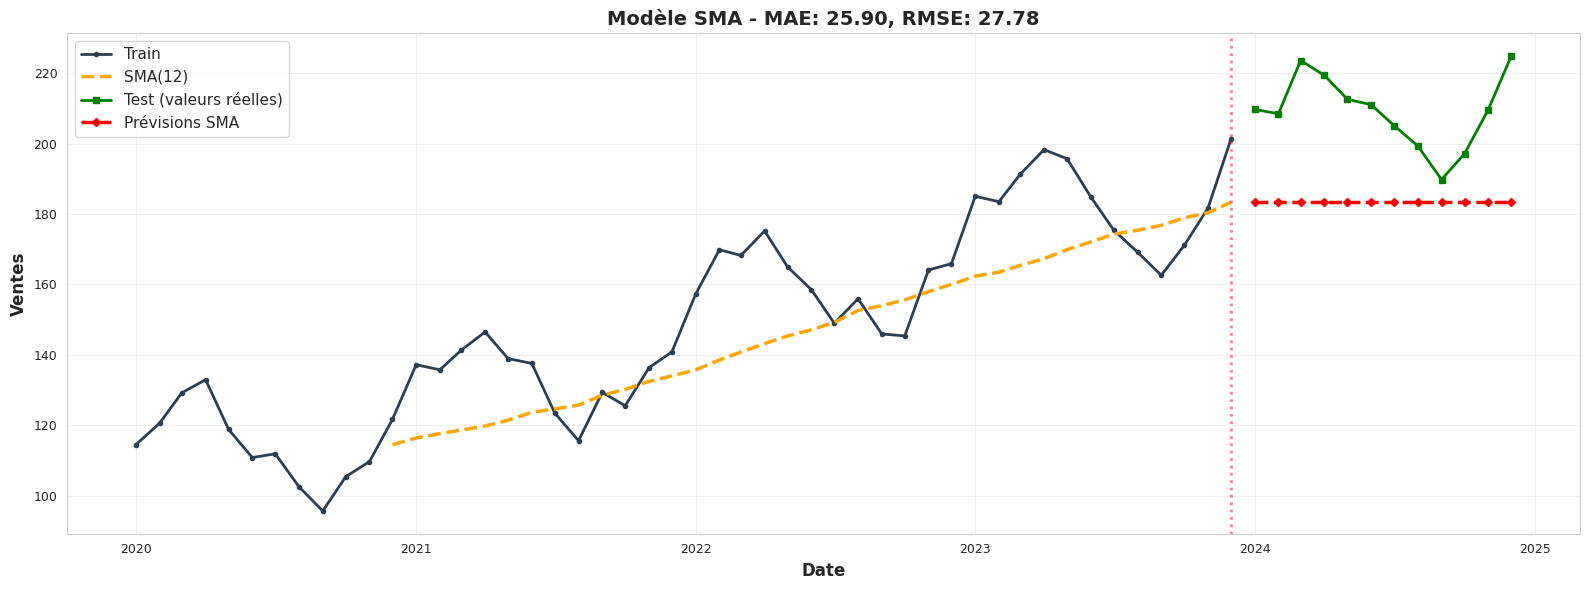


⚠️ LIMITES:
- Ne capture PAS la tendance croissante
- Ne capture PAS la saisonnalité
- Prévision constante = peu performante


In [19]:
"""
Modèle de base: prévision basée sur la moyenne des dernières observations
"""
print("\n" + "=" * 70)
print("MODÈLE 1: MOYENNE MOBILE SIMPLE (SMA)")
print("=" * 70)

print("\n📚 PRINCIPE:")
print("Prévision = Moyenne des k dernières observations")
print("Formule: Ŷ(t+1) = (1/k) × Σ Y(t-i) pour i=0 à k-1")

# Paramètres
window_sma = 12

# Calcul de la moyenne mobile
sma_values = train['ventes'].rolling(window=window_sma).mean()
sma_last = sma_values.iloc[-1]

# Prévision: on répète la dernière moyenne
sma_forecast = np.full(len(test), sma_last)

# Métriques
mae_sma = mean_absolute_error(test['ventes'], sma_forecast)
rmse_sma = np.sqrt(mean_squared_error(test['ventes'], sma_forecast))
mape_sma = np.mean(np.abs((test['ventes'] - sma_forecast) / test['ventes'])) * 100

print(f"\n--- Résultats SMA (fenêtre={window_sma}) ---")
print(f"Dernière moyenne mobile: {sma_last:.2f}")
print(f"MAE:  {mae_sma:.2f}")
print(f"RMSE: {rmse_sma:.2f}")
print(f"MAPE: {mape_sma:.2f}%")

# Visualisation
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
        label='Train', marker='o', markersize=3)
ax.plot(train.index, sma_values, linewidth=2.5, color='orange',
        linestyle='--', label=f'SMA({window_sma})')
ax.plot(test.index, test['ventes'], linewidth=2, color='green',
        label='Test (valeurs réelles)', marker='s', markersize=4)
ax.plot(test.index, sma_forecast, linewidth=2.5, color='red',
        linestyle='--', label='Prévisions SMA', marker='D', markersize=4)
ax.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title(f'Modèle SMA - MAE: {mae_sma:.2f}, RMSE: {rmse_sma:.2f}',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ LIMITES:")
print("- Ne capture PAS la tendance croissante")
print("- Ne capture PAS la saisonnalité")
print("- Prévision constante = peu performante")



MODÈLE 2: LISSAGE EXPONENTIEL SIMPLE (SES)

📚 PRINCIPE:
Prévision pondérée avec poids décroissants exponentiellement
Formule: Ŷ(t+1) = α×Y(t) + (1-α)×Ŷ(t)
où α = paramètre de lissage (0 < α < 1)

--- Résultats SES ---
Paramètre α (alpha): 1.0000
MAE:  10.88
RMSE: 12.81
MAPE: 5.10%


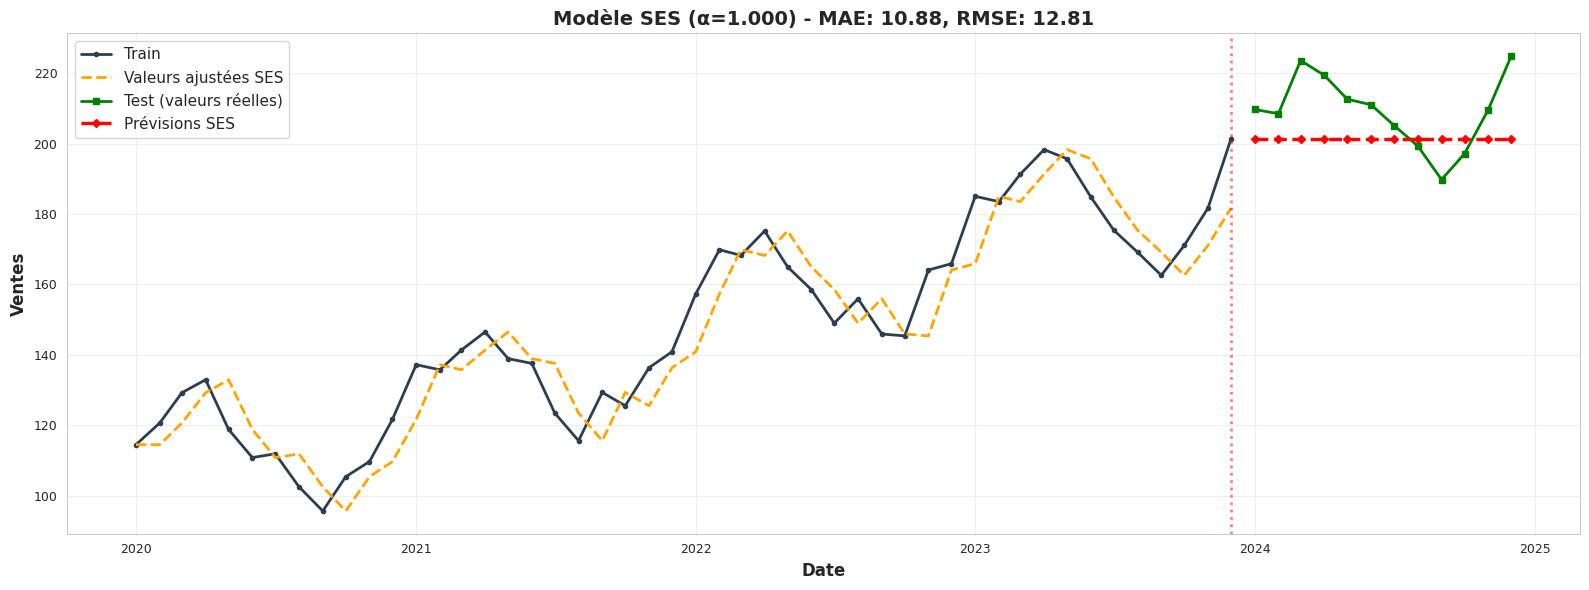


⚠️ LIMITES:
- Ne capture PAS la tendance
- Ne capture PAS la saisonnalité
- Meilleur que SMA mais encore insuffisant


In [20]:
"""
Lissage exponentiel simple: pondération décroissante des observations
"""
print("\n" + "=" * 70)
print("MODÈLE 2: LISSAGE EXPONENTIEL SIMPLE (SES)")
print("=" * 70)

print("\n📚 PRINCIPE:")
print("Prévision pondérée avec poids décroissants exponentiellement")
print("Formule: Ŷ(t+1) = α×Y(t) + (1-α)×Ŷ(t)")
print("où α = paramètre de lissage (0 < α < 1)")

# Entraînement du modèle
ses_model = SimpleExpSmoothing(train['ventes']).fit(optimized=True)
alpha_ses = ses_model.params['smoothing_level']

# Prévisions
ses_forecast = ses_model.forecast(steps=len(test))
ses_fitted = ses_model.fittedvalues

# Métriques
mae_ses = mean_absolute_error(test['ventes'], ses_forecast)
rmse_ses = np.sqrt(mean_squared_error(test['ventes'], ses_forecast))
mape_ses = np.mean(np.abs((test['ventes'] - ses_forecast) / test['ventes'])) * 100

print(f"\n--- Résultats SES ---")
print(f"Paramètre α (alpha): {alpha_ses:.4f}")
print(f"MAE:  {mae_ses:.2f}")
print(f"RMSE: {rmse_ses:.2f}")
print(f"MAPE: {mape_ses:.2f}%")

# Visualisation
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
        label='Train', marker='o', markersize=3)
ax.plot(train.index, ses_fitted, linewidth=2, color='orange',
        linestyle='--', label='Valeurs ajustées SES')
ax.plot(test.index, test['ventes'], linewidth=2, color='green',
        label='Test (valeurs réelles)', marker='s', markersize=4)
ax.plot(test.index, ses_forecast, linewidth=2.5, color='red',
        linestyle='--', label='Prévisions SES', marker='D', markersize=4)
ax.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title(f'Modèle SES (α={alpha_ses:.3f}) - MAE: {mae_ses:.2f}, RMSE: {rmse_ses:.2f}',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️ LIMITES:")
print("- Ne capture PAS la tendance")
print("- Ne capture PAS la saisonnalité")
print("- Meilleur que SMA mais encore insuffisant")


MODÈLE 4: HOLT-WINTERS (TRIPLE EXPONENTIEL)

📚 PRINCIPE:
Extension de Holt pour capturer la SAISONNALITÉ
Trois équations:
  Niveau:        l(t) = α×(Y(t)/s(t-m)) + (1-α)×(l(t-1) + b(t-1))
  Tendance:      b(t) = β×(l(t) - l(t-1)) + (1-β)×b(t-1)
  Saisonnalité:  s(t) = γ×(Y(t)/l(t)) + (1-γ)×s(t-m)
  Prévision:     Ŷ(t+h) = (l(t) + h×b(t)) × s(t-m+h)

--- Résultats Holt-Winters ---
Paramètre α (niveau): 0.0000
Paramètre β (tendance): 0.0000
Paramètre γ (saisonnalité): 0.0000

Métriques:
MAE:  4.11
RMSE: 4.92
MAPE: 1.94%
R²:   0.7593


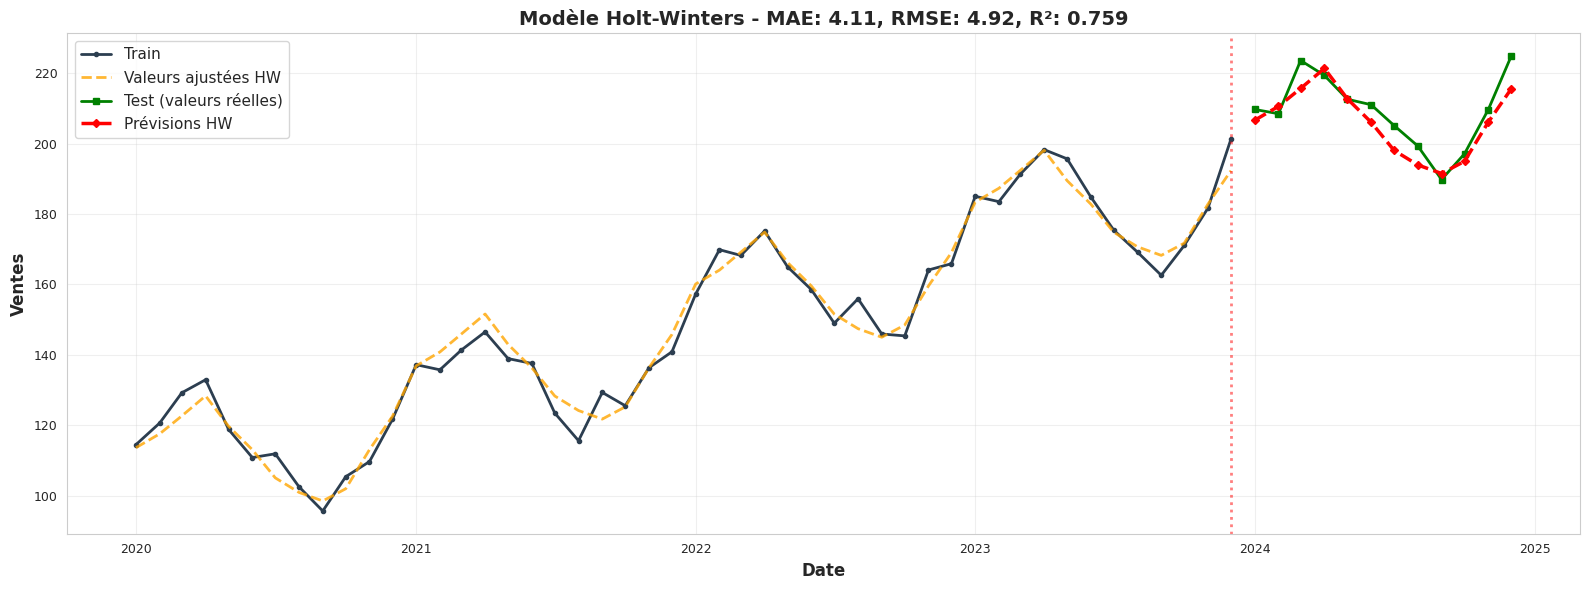


✓✓✓ EXCELLENTE AMÉLIORATION!
- Capture la TENDANCE
- Capture la SAISONNALITÉ
- Prévisions beaucoup plus précises


In [55]:
"""
Lissage exponentiel triple: capture tendance + saisonnalité
"""
print("\n" + "=" * 70)
print("MODÈLE 4: HOLT-WINTERS (TRIPLE EXPONENTIEL)")
print("=" * 70)

print("\n📚 PRINCIPE:")
print("Extension de Holt pour capturer la SAISONNALITÉ")
print("Trois équations:")
print("  Niveau:        l(t) = α×(Y(t)/s(t-m)) + (1-α)×(l(t-1) + b(t-1))")
print("  Tendance:      b(t) = β×(l(t) - l(t-1)) + (1-β)×b(t-1)")
print("  Saisonnalité:  s(t) = γ×(Y(t)/l(t)) + (1-γ)×s(t-m)")
print("  Prévision:     Ŷ(t+h) = (l(t) + h×b(t)) × s(t-m+h)")

# Entraînement du modèle (multiplicatif)
hw_model = ExponentialSmoothing(
    train['ventes'],
    seasonal_periods=12,
    trend='add',
    seasonal='add'
).fit(optimized=True)

alpha_hw = hw_model.params['smoothing_level']
beta_hw = hw_model.params['smoothing_trend']
gamma_hw = hw_model.params['smoothing_seasonal']

# Prévisions
hw_forecast = hw_model.forecast(steps=len(test))
hw_fitted = hw_model.fittedvalues

# Métriques
mae_hw = mean_absolute_error(test['ventes'], hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test['ventes'], hw_forecast))
mape_hw = np.mean(np.abs((test['ventes'] - hw_forecast) / test['ventes'])) * 100
r2_hw = r2_score(test['ventes'], hw_forecast)

print(f"\n--- Résultats Holt-Winters ---")
print(f"Paramètre α (niveau): {alpha_hw:.4f}")
print(f"Paramètre β (tendance): {beta_hw:.4f}")
print(f"Paramètre γ (saisonnalité): {gamma_hw:.4f}")
print(f"\nMétriques:")
print(f"MAE:  {mae_hw:.2f}")
print(f"RMSE: {rmse_hw:.2f}")
print(f"MAPE: {mape_hw:.2f}%")
print(f"R²:   {r2_hw:.4f}")

# Visualisation
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(train.index, train['ventes'], linewidth=2, color='#2C3E50',
        label='Train', marker='o', markersize=3)
ax.plot(train.index, hw_fitted, linewidth=2, color='orange',
        linestyle='--', label='Valeurs ajustées HW', alpha=0.8)
ax.plot(test.index, test['ventes'], linewidth=2, color='green',
        label='Test (valeurs réelles)', marker='s', markersize=4)
ax.plot(test.index, hw_forecast, linewidth=2.5, color='red',
        linestyle='--', label='Prévisions HW', marker='D', markersize=4)
ax.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5)
ax.set_title(f'Modèle Holt-Winters - MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}, R²: {r2_hw:.3f}',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Ventes', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓✓✓ EXCELLENTE AMÉLIORATION!")
print("- Capture la TENDANCE")
print("- Capture la SAISONNALITÉ")
print("- Prévisions beaucoup plus précises")


COMPARAISON DES MODÈLES DE LISSAGE EXPONENTIEL

       Modèle       MAE      RMSE  MAPE (%)     R² Tendance Saisonnalité
         SMA 25.902468 27.779587 12.174731      -      Non          Non
         SES 10.884569 12.807547  5.099006      -      Non          Non
        Holt 14.538722 18.142947  7.150256      -      Oui          Non
Holt-Winters  4.111652  4.924439  1.941765 0.7593      Oui          Oui


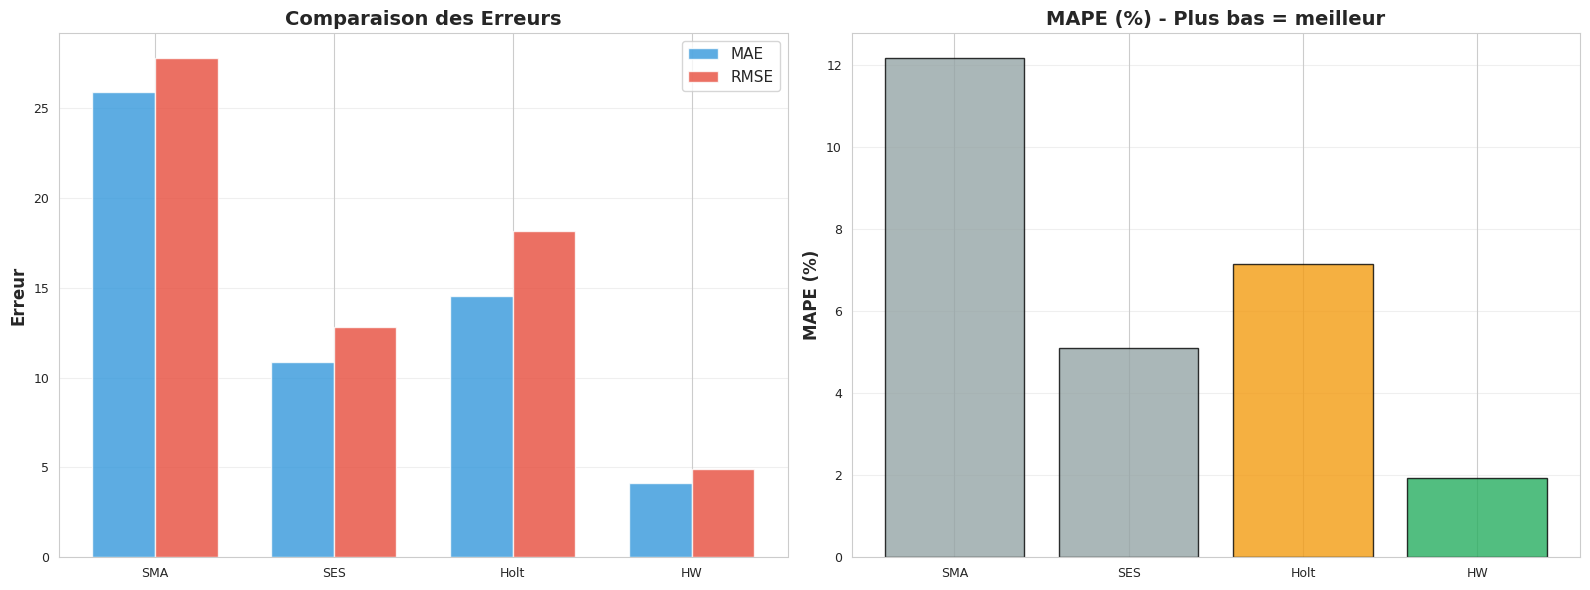


🏆 MEILLEUR MODÈLE: Holt-Winters
   MAE: 4.11, RMSE: 4.92, MAPE: 1.94%


In [56]:
"""
Tableau comparatif de tous les modèles de lissage
"""
print("\n" + "=" * 70)
print("COMPARAISON DES MODÈLES DE LISSAGE EXPONENTIEL")
print("=" * 70)

# Création du tableau comparatif
comparison_smoothing = pd.DataFrame({
    'Modèle': ['SMA', 'SES', 'Holt', 'Holt-Winters'],
    'MAE': [mae_sma, mae_ses, mae_holt, mae_hw],
    'RMSE': [rmse_sma, rmse_ses, rmse_holt, rmse_hw],
    'MAPE (%)': [mape_sma, mape_ses, mape_holt, mape_hw],
    'R²': ['-', '-', '-', f'{r2_hw:.4f}'],
    'Tendance': ['Non', 'Non', 'Oui', 'Oui'],
    'Saisonnalité': ['Non', 'Non', 'Non', 'Oui']
})

print("\n", comparison_smoothing.to_string(index=False))

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Comparaison des erreurs
models = ['SMA', 'SES', 'Holt', 'HW']
mae_values = [mae_sma, mae_ses, mae_holt, mae_hw]
rmse_values = [rmse_sma, rmse_ses, rmse_holt, rmse_hw]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, mae_values, width, label='MAE', color='#3498DB', alpha=0.8)
axes[0].bar(x + width/2, rmse_values, width, label='RMSE', color='#E74C3C', alpha=0.8)
axes[0].set_title('Comparaison des Erreurs', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Erreur', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Graphique 2: MAPE
axes[1].bar(models, [mape_sma, mape_ses, mape_holt, mape_hw],
           color=['#95A5A6', '#95A5A6', '#F39C12', '#27AE60'], alpha=0.8, edgecolor='black')
axes[1].set_title('MAPE (%) - Plus bas = meilleur', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n🏆 MEILLEUR MODÈLE: Holt-Winters")
print(f"   MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}, MAPE: {mape_hw:.2f}%")

In [62]:
"""
Application directe des fonctions d'activation non-linéaires
sur les composantes de la série temporelle
"""
print("\n" + "=" * 70)
print("APPLICATION DES NON-LINÉARITÉS AUX SÉRIES TEMPORELLES")
print("=" * 70)

# Fonctions d'activation non-linéaires
def relu(x):
    """Fonction ReLU (Rectified Linear Unit)"""
    return np.maximum(0, x)

def sigmoid(x):
    """Fonction Sigmoïde"""
    return 1 / (1 + np.exp(-x))

def tanh(x):
    """Fonction Tangente Hyperbolique"""
    return np.tanh(x)

def leaky_relu(x, alpha=0.01):
    """Fonction Leaky ReLU"""
    return np.where(x > 0, x, alpha * x)

def softplus(x):
    """Fonction Softplus (approximation lisse de ReLU)"""
    return np.log(1 + np.exp(x))

print("\n--- Application des non-linéarités aux composantes de la série ---")

# 1. Application de ReLU à la tendance (seuil à t=30)
tendance_relu = tendance + 10 * relu(t - 30)
print("✓ ReLU appliquée: rupture de tendance à t=30")

# 2. Application de sigmoïde à la saisonnalité (changement d'amplitude)
saisonnalite_sigmoid = 25 * sigmoid((t - 30) / 8) * np.sin(2 * np.pi * t / P)
print("✓ Sigmoïde appliquée: modulation progressive de l'amplitude saisonnière")

# 3. Application de tanh pour créer une saturation
composante_saturation = 15 * tanh((t - 45) / 10)
print("✓ Tanh appliquée: saturation progressive après t=45")

# 4. Application de Leaky ReLU au bruit (asymétrie)
bruit_leaky_relu = 3 * leaky_relu(bruit)
print("✓ Leaky ReLU appliquée: bruit asymétrique")

# 5. Création de séries avec différentes non-linéarités
ventes_relu_applique = tendance_relu + saisonnalite + bruit
ventes_sigmoid_applique = tendance + saisonnalite_sigmoid + bruit
ventes_tanh_applique = tendance + saisonnalite + composante_saturation + bruit
ventes_mixte = tendance_relu + saisonnalite_sigmoid + bruit_leaky_relu

# 6. Application directe des fonctions sur la série complète
ventes_relu_direct = 100 + 50 * relu((ventes - 150) / 20)
ventes_sigmoid_direct = 80 + 80 * sigmoid((ventes - 160) / 15)

# Ajout au DataFrame
df['tendance_relu'] = tendance_relu
df['saisonnalite_sigmoid'] = saisonnalite_sigmoid
df['composante_saturation'] = composante_saturation
df['ventes_relu_applique'] = ventes_relu_applique
df['ventes_sigmoid_applique'] = ventes_sigmoid_applique
df['ventes_tanh_applique'] = ventes_tanh_applique
df['ventes_mixte'] = ventes_mixte
df['ventes_relu_direct'] = ventes_relu_direct
df['ventes_sigmoid_direct'] = ventes_sigmoid_direct

print("\n✓ 8 séries non-linéaires créées avec succès!")
print("  • ReLU: rupture brutale")
print("  • Sigmoïde: transition douce")
print("  • Tanh: saturation")
print("  • Combinaisons multiples")


APPLICATION DES NON-LINÉARITÉS AUX SÉRIES TEMPORELLES

--- Application des non-linéarités aux composantes de la série ---
✓ ReLU appliquée: rupture de tendance à t=30
✓ Sigmoïde appliquée: modulation progressive de l'amplitude saisonnière
✓ Tanh appliquée: saturation progressive après t=45
✓ Leaky ReLU appliquée: bruit asymétrique

✓ 8 séries non-linéaires créées avec succès!
  • ReLU: rupture brutale
  • Sigmoïde: transition douce
  • Tanh: saturation
  • Combinaisons multiples



VISUALISATION DES EFFETS TEMPORELS DES NON-LINÉARITÉS


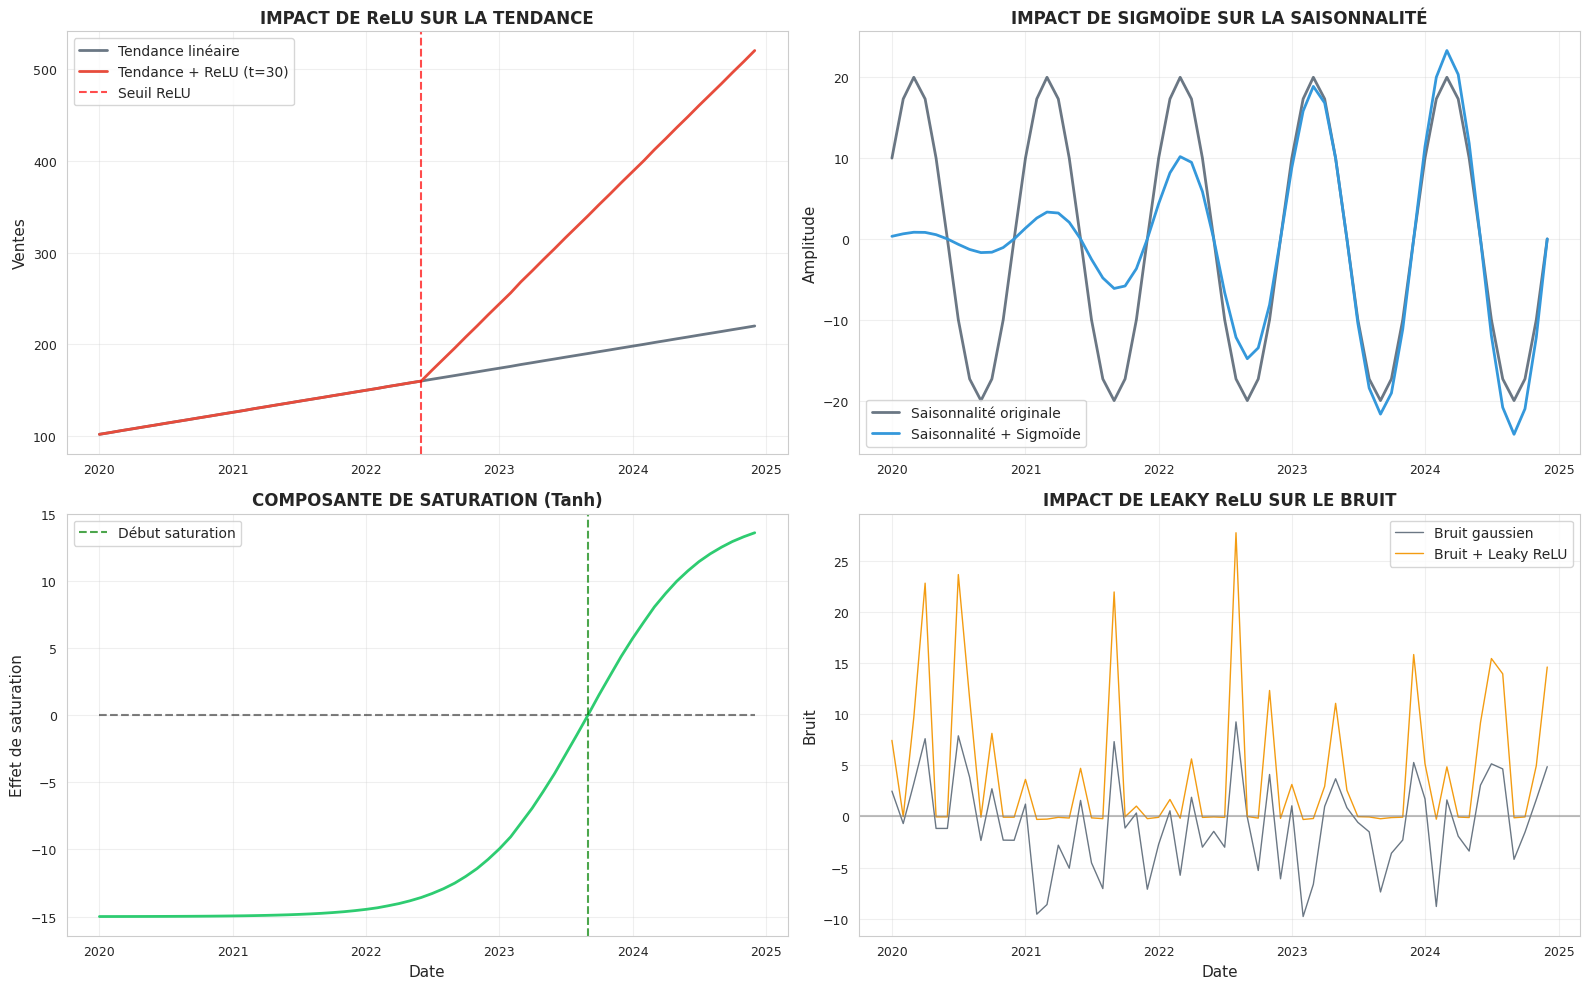

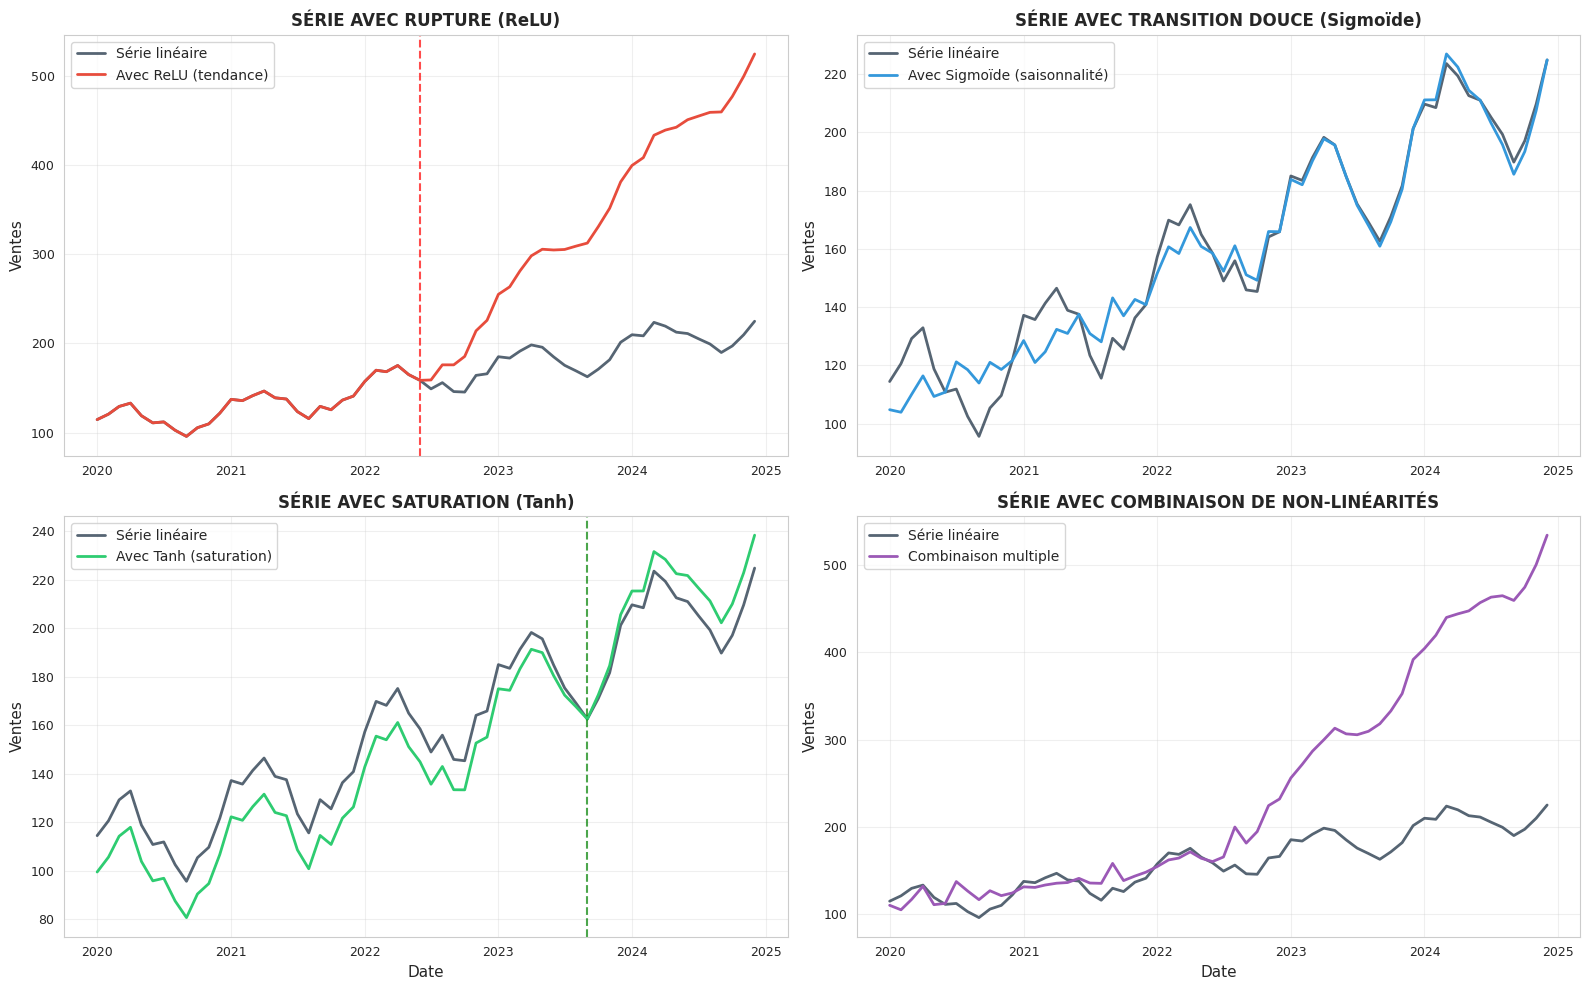

✓ Visualisations temporelles des non-linéarités terminées!


In [63]:
# ========================================================================
# CELLULE 8: VISUALISATION DES EFFETS TEMPORELS DES NON-LINÉARITÉS
# ========================================================================
"""
Visualisation détaillée montrant l'impact des fonctions d'activation
sur l'évolution temporelle des séries
"""
print("\n" + "=" * 70)
print("VISUALISATION DES EFFETS TEMPORELS DES NON-LINÉARITÉS")
print("=" * 70)

# Graphique 1: Impact sur les composantes individuelles
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Tendance linéaire vs ReLU
axes[0, 0].plot(df.index, df['tendance'], linewidth=2, color='#2C3E50',
                label='Tendance linéaire', alpha=0.7)
axes[0, 0].plot(df.index, df['tendance_relu'], linewidth=2, color='#E74C3C',
                label='Tendance + ReLU (t=30)')
axes[0, 0].axvline(x=df.index[29], color='red', linestyle='--', alpha=0.7,
                   label='Seuil ReLU')
axes[0, 0].set_title('IMPACT DE ReLU SUR LA TENDANCE', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Ventes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Saisonnalité originale vs Sigmoïde
axes[0, 1].plot(df.index, df['saisonnalite'], linewidth=2, color='#2C3E50',
                label='Saisonnalité originale', alpha=0.7)
axes[0, 1].plot(df.index, df['saisonnalite_sigmoid'], linewidth=2, color='#3498DB',
                label='Saisonnalité + Sigmoïde')
axes[0, 1].set_title('IMPACT DE SIGMOÏDE SUR LA SAISONNALITÉ', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Saturation avec Tanh
axes[1, 0].plot(df.index, np.zeros_like(t), 'k--', alpha=0.5)
axes[1, 0].plot(df.index, df['composante_saturation'], linewidth=2, color='#2ECC71')
axes[1, 0].axvline(x=df.index[44], color='green', linestyle='--', alpha=0.7,
                   label='Début saturation')
axes[1, 0].set_title('COMPOSANTE DE SATURATION (Tanh)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Effet de saturation')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bruit original vs Leaky ReLU
axes[1, 1].plot(df.index, df['bruit'], linewidth=1, color='#2C3E50',
                label='Bruit gaussien', alpha=0.7)
axes[1, 1].plot(df.index, bruit_leaky_relu, linewidth=1, color='#F39C12',
                label='Bruit + Leaky ReLU')
axes[1, 1].axhline(y=0, color='gray', linestyle='-', alpha=0.5)
axes[1, 1].set_title('IMPACT DE LEAKY ReLU SUR LE BRUIT', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Bruit')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Graphique 2: Comparaison des séries complètes
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Série originale vs ReLU appliquée
axes[0, 0].plot(df.index, df['ventes'], linewidth=2, color='#2C3E50',
                label='Série linéaire', alpha=0.8)
axes[0, 0].plot(df.index, df['ventes_relu_applique'], linewidth=2, color='#E74C3C',
                label='Avec ReLU (tendance)')
axes[0, 0].axvline(x=df.index[29], color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('SÉRIE AVEC RUPTURE (ReLU)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Ventes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Série originale vs Sigmoïde appliquée
axes[0, 1].plot(df.index, df['ventes'], linewidth=2, color='#2C3E50',
                label='Série linéaire', alpha=0.8)
axes[0, 1].plot(df.index, df['ventes_sigmoid_applique'], linewidth=2, color='#3498DB',
                label='Avec Sigmoïde (saisonnalité)')
axes[0, 1].set_title('SÉRIE AVEC TRANSITION DOUCE (Sigmoïde)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Ventes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Série avec saturation (Tanh)
axes[1, 0].plot(df.index, df['ventes'], linewidth=2, color='#2C3E50',
                label='Série linéaire', alpha=0.8)
axes[1, 0].plot(df.index, df['ventes_tanh_applique'], linewidth=2, color='#2ECC71',
                label='Avec Tanh (saturation)')
axes[1, 0].axvline(x=df.index[44], color='green', linestyle='--', alpha=0.7)
axes[1, 0].set_title('SÉRIE AVEC SATURATION (Tanh)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Ventes')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Série mixte (combinaison multiple)
axes[1, 1].plot(df.index, df['ventes'], linewidth=2, color='#2C3E50',
                label='Série linéaire', alpha=0.8)
axes[1, 1].plot(df.index, df['ventes_mixte'], linewidth=2, color='#9B59B6',
                label='Combinaison multiple')
axes[1, 1].set_title('SÉRIE AVEC COMBINAISON DE NON-LINÉARITÉS', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Ventes')
axes[1, 1].set_xlabel('Date')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualisations temporelles des non-linéarités terminées!")


FONCTIONS D'ACTIVATION ET LEURS EFFETS SUR SIGNAL TEMPOREL


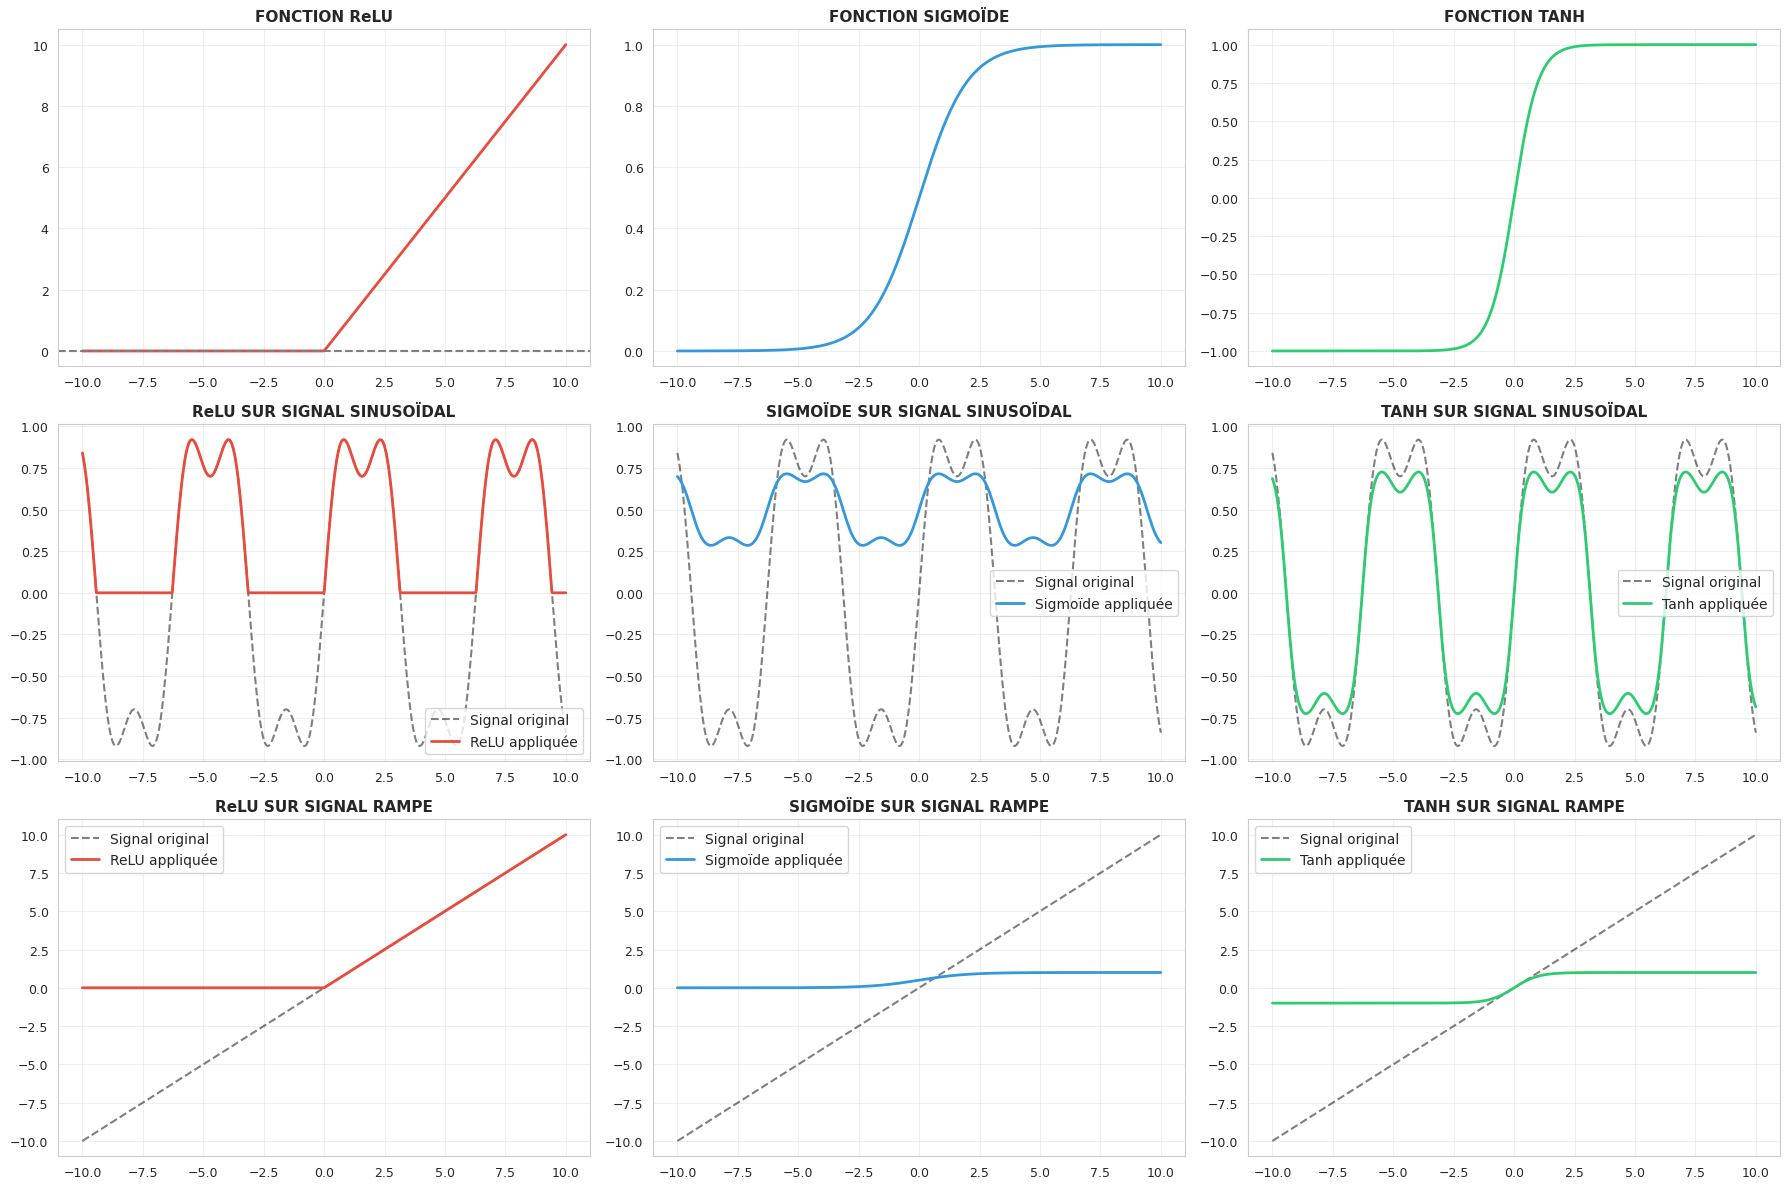

✓ Visualisation des fonctions d'activation et de leurs effets terminée!


In [64]:
"""
Visualisation des fonctions d'activation et de leurs effets
sur des signaux temporels synthétiques
"""
print("\n" + "=" * 70)
print("FONCTIONS D'ACTIVATION ET LEURS EFFETS SUR SIGNAL TEMPOREL")
print("=" * 70)

# Création d'un signal temporel synthétique pour démonstration
t_signal = np.linspace(-10, 10, 1000)
signal_sinus = np.sin(t_signal) + 0.3 * np.sin(3 * t_signal)  # Signal riche en fréquences
signal_rampe = t_signal  # Signal linéaire

fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Ligne 1: Fonctions d'activation pures
axes[0, 0].plot(t_signal, relu(t_signal), linewidth=2, color='#E74C3C')
axes[0, 0].set_title('FONCTION ReLU', fontsize=11, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='gray', linestyle='--')

axes[0, 1].plot(t_signal, sigmoid(t_signal), linewidth=2, color='#3498DB')
axes[0, 1].set_title('FONCTION SIGMOÏDE', fontsize=11, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(t_signal, tanh(t_signal), linewidth=2, color='#2ECC71')
axes[0, 2].set_title('FONCTION TANH', fontsize=11, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Ligne 2: Application sur signal sinusoïdal
axes[1, 0].plot(t_signal, signal_sinus, 'k--', alpha=0.5, label='Signal original')
axes[1, 0].plot(t_signal, relu(signal_sinus), linewidth=2, color='#E74C3C', label='ReLU appliquée')
axes[1, 0].set_title('ReLU SUR SIGNAL SINUSOÏDAL', fontsize=11, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(t_signal, signal_sinus, 'k--', alpha=0.5, label='Signal original')
axes[1, 1].plot(t_signal, sigmoid(signal_sinus), linewidth=2, color='#3498DB', label='Sigmoïde appliquée')
axes[1, 1].set_title('SIGMOÏDE SUR SIGNAL SINUSOÏDAL', fontsize=11, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(t_signal, signal_sinus, 'k--', alpha=0.5, label='Signal original')
axes[1, 2].plot(t_signal, tanh(signal_sinus), linewidth=2, color='#2ECC71', label='Tanh appliquée')
axes[1, 2].set_title('TANH SUR SIGNAL SINUSOÏDAL', fontsize=11, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Ligne 3: Application sur signal rampe
axes[2, 0].plot(t_signal, signal_rampe, 'k--', alpha=0.5, label='Signal original')
axes[2, 0].plot(t_signal, relu(signal_rampe), linewidth=2, color='#E74C3C', label='ReLU appliquée')
axes[2, 0].set_title('ReLU SUR SIGNAL RAMPE', fontsize=11, fontweight='bold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(t_signal, signal_rampe, 'k--', alpha=0.5, label='Signal original')
axes[2, 1].plot(t_signal, sigmoid(signal_rampe), linewidth=2, color='#3498DB', label='Sigmoïde appliquée')
axes[2, 1].set_title('SIGMOÏDE SUR SIGNAL RAMPE', fontsize=11, fontweight='bold')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].plot(t_signal, signal_rampe, 'k--', alpha=0.5, label='Signal original')
axes[2, 2].plot(t_signal, tanh(signal_rampe), linewidth=2, color='#2ECC71', label='Tanh appliquée')
axes[2, 2].set_title('TANH SUR SIGNAL RAMPE', fontsize=11, fontweight='bold')
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualisation des fonctions d'activation et de leurs effets terminée!")

In [61]:
"""
Préparation des données pour l'analyse avec réseaux de neurones
Mise en place des structures nécessaires
"""
print("\n" + "=" * 70)
print("PRÉPARATION POUR RÉSEAUX DE NEURONES")
print("=" * 70)

# Normalisation des données (essentielle pour les RN)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Préparation des séries pour normalisation
series_to_normalize = ['ventes', 'ventes_non_lineaires', 'ventes_relu', 'ventes_sigmoid']
normalized_data = {}

for series_name in series_to_normalize:
    normalized = scaler.fit_transform(df[[series_name]])
    normalized_data[series_name] = normalized.flatten()
    df[f'{series_name}_normalisee'] = normalized.flatten()

print("✓ Données normalisées pour réseaux de neurones")

# Création de séquences (pour approche supervisée)
def create_sequences(data, sequence_length=12):
    """Crée des séquences pour l'apprentissage supervisé"""
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:(i + sequence_length)])
        targets.append(data[i + sequence_length])
    return np.array(sequences), np.array(targets)

# Exemple pour la série non-linéaire
sequence_length = 6  # Utiliser 6 mois pour prédire le 7ème
X_seq, y_seq = create_sequences(normalized_data['ventes_non_lineaires'], sequence_length)

print(f"\n--- Structure des données pour réseaux de neurones ---")
print(f"Shape des séquences (X): {X_seq.shape}")
print(f"Shape des cibles (y): {y_seq.shape}")
print(f"Exemple de séquence: {X_seq[0]}")
print(f"Cible correspondante: {y_seq[0]}")

print("\n✓ Données préparées pour modélisation par réseaux de neurones")
print("  • Normalisation Min-Max appliquée")
print("  • Séquences créées pour apprentissage supervisé")
print("  • Structure prête pour LSTM/RNN")


PRÉPARATION POUR RÉSEAUX DE NEURONES
✓ Données normalisées pour réseaux de neurones

--- Structure des données pour réseaux de neurones ---
Shape des séquences (X): (54, 6)
Shape des cibles (y): (54,)
Exemple de séquence: [0.08589775 0.11393111 0.15320242 0.17006734 0.10572058 0.06922878]
Cible correspondante: 0.07409478288577043

✓ Données préparées pour modélisation par réseaux de neurones
  • Normalisation Min-Max appliquée
  • Séquences créées pour apprentissage supervisé
  • Structure prête pour LSTM/RNN



ANALYSE AVEC ZOOM SUR LES TRANSITIONS NON-LINÉAIRES


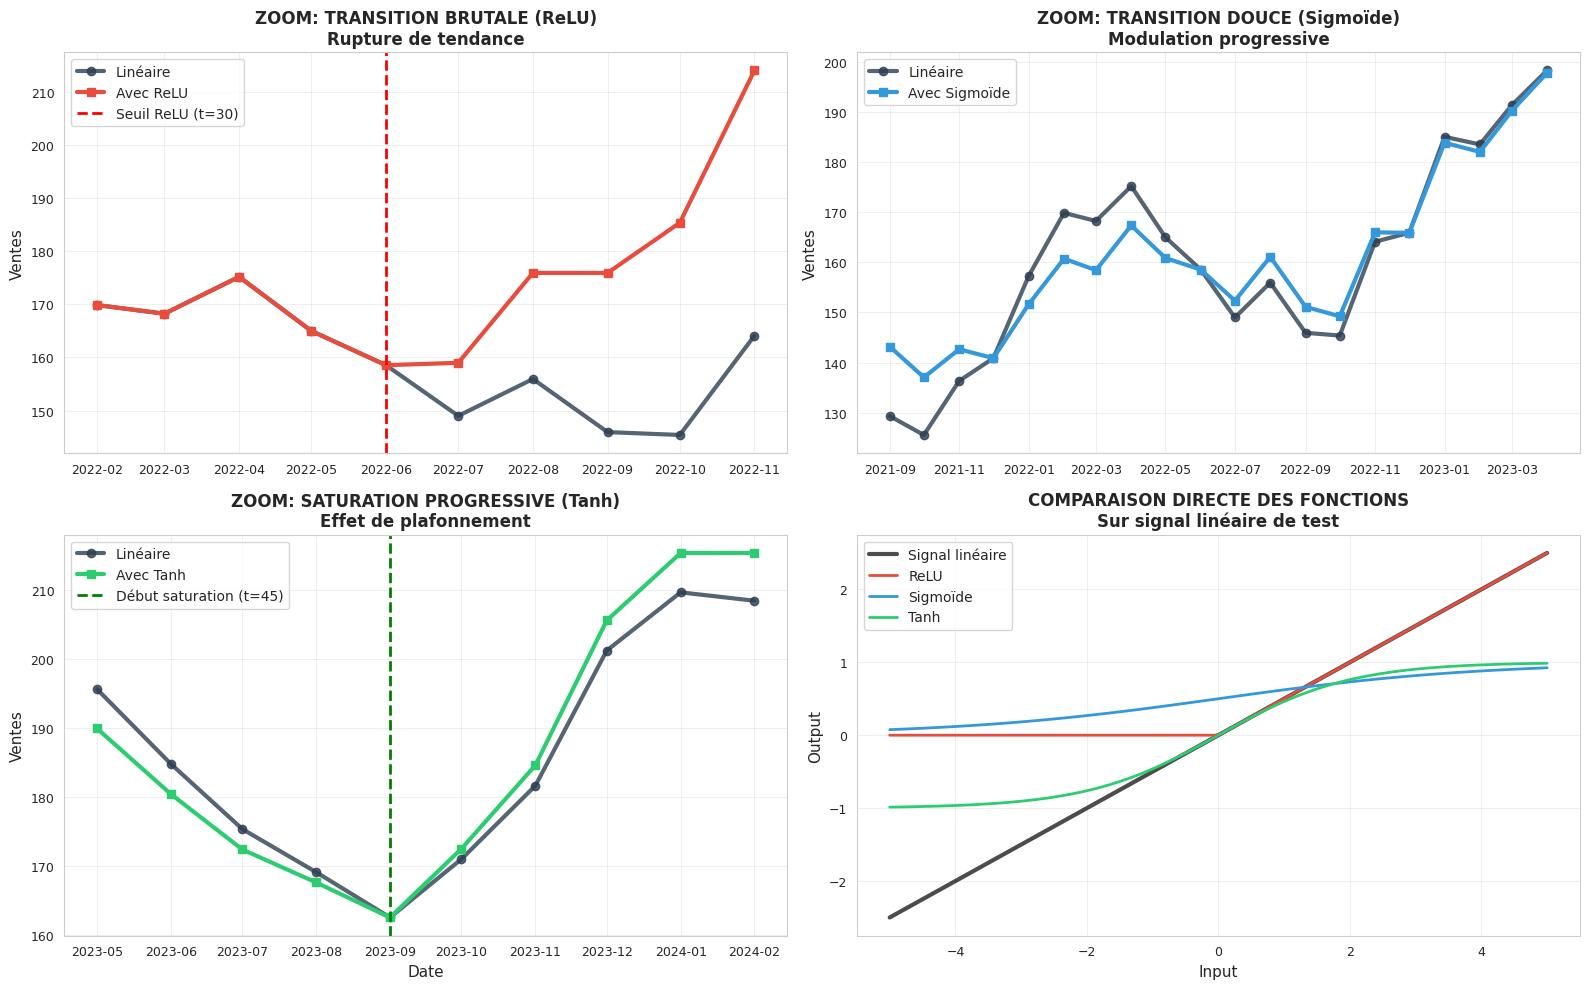


✓ Analyse avec zoom terminée!

--- SYNTHÈSE PÉDAGOGIQUE ---
• ReLU: Crée des ruptures BRUTALES (dérivée discontinue)
• Sigmoïde: Crée des transitions DOUCES (dérivée continue)
• Tanh: Permet la SATURATION (valeurs bornées entre -1 et 1)
• Ces non-linéarités permettent aux réseaux de neurones de:
  - Capturer des comportements complexes
  - Modéliser des seuils et ruptures
  - Apprendre des relations non-linéaires dans le temps


In [65]:
"""
Analyse détaillée avec zoom sur les périodes de transition
pour mieux visualiser les effets des non-linéarités
"""
print("\n" + "=" * 70)
print("ANALYSE AVEC ZOOM SUR LES TRANSITIONS NON-LINÉAIRES")
print("=" * 70)

# Périodes de zoom pour analyser les transitions
periode_relu = slice(25, 35)    # Autour de t=30 (ReLU)
periode_sigmoid = slice(20, 40) # Transition progressive sigmoïde
periode_tanh = slice(40, 50)    # Saturation Tanh

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Zoom sur transition ReLU
axes[0, 0].plot(df.index[periode_relu], df['ventes'][periode_relu],
                linewidth=3, color='#2C3E50', marker='o', label='Linéaire', alpha=0.8)
axes[0, 0].plot(df.index[periode_relu], df['ventes_relu_applique'][periode_relu],
                linewidth=3, color='#E74C3C', marker='s', label='Avec ReLU')
axes[0, 0].axvline(x=df.index[29], color='red', linestyle='--', linewidth=2,
                   label='Seuil ReLU (t=30)')
axes[0, 0].set_title('ZOOM: TRANSITION BRUTALE (ReLU)\nRupture de tendance',
                     fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Ventes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Zoom sur transition Sigmoïde
axes[0, 1].plot(df.index[periode_sigmoid], df['ventes'][periode_sigmoid],
                linewidth=3, color='#2C3E50', marker='o', label='Linéaire', alpha=0.8)
axes[0, 1].plot(df.index[periode_sigmoid], df['ventes_sigmoid_applique'][periode_sigmoid],
                linewidth=3, color='#3498DB', marker='s', label='Avec Sigmoïde')
axes[0, 1].set_title('ZOOM: TRANSITION DOUCE (Sigmoïde)\nModulation progressive',
                     fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Ventes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Zoom sur saturation Tanh
axes[1, 0].plot(df.index[periode_tanh], df['ventes'][periode_tanh],
                linewidth=3, color='#2C3E50', marker='o', label='Linéaire', alpha=0.8)
axes[1, 0].plot(df.index[periode_tanh], df['ventes_tanh_applique'][periode_tanh],
                linewidth=3, color='#2ECC71', marker='s', label='Avec Tanh')
axes[1, 0].axvline(x=df.index[44], color='green', linestyle='--', linewidth=2,
                   label='Début saturation (t=45)')
axes[1, 0].set_title('ZOOM: SATURATION PROGRESSIVE (Tanh)\nEffet de plafonnement',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Ventes')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comparaison directe des fonctions sur même signal
t_test = np.linspace(-5, 5, 100)
signal_test = 0.5 * t_test
axes[1, 1].plot(t_test, signal_test, 'k-', linewidth=3, label='Signal linéaire', alpha=0.7)
axes[1, 1].plot(t_test, relu(signal_test), linewidth=2, color='#E74C3C', label='ReLU')
axes[1, 1].plot(t_test, sigmoid(signal_test), linewidth=2, color='#3498DB', label='Sigmoïde')
axes[1, 1].plot(t_test, tanh(signal_test), linewidth=2, color='#2ECC71', label='Tanh')
axes[1, 1].set_title('COMPARAISON DIRECTE DES FONCTIONS\nSur signal linéaire de test',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Input')
axes[1, 1].set_ylabel('Output')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Analyse avec zoom terminée!")
print("\n--- SYNTHÈSE PÉDAGOGIQUE ---")
print("• ReLU: Crée des ruptures BRUTALES (dérivée discontinue)")
print("• Sigmoïde: Crée des transitions DOUCES (dérivée continue)")
print("• Tanh: Permet la SATURATION (valeurs bornées entre -1 et 1)")
print("• Ces non-linéarités permettent aux réseaux de neurones de:")
print("  - Capturer des comportements complexes")
print("  - Modéliser des seuils et ruptures")
print("  - Apprendre des relations non-linéaires dans le temps")